# Extracting relevant information to construct seed values for linear mixing endmember spectra

In [1]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import gaussian_kde


import torch
import torch .nn as nn
import torch .optim as optim

import json

import gc

from tqdm.notebook import tqdm

plt.rcParams['text.usetex'] = True

In [2]:
data = np.loadtxt("../data/RaCA-spectra-raw.txt",
                 delimiter=",", dtype=str)

In [3]:
data[0,2152:]
sample_top   = data[1:,2153].astype('float32')
sample_bot   = data[1:,2154].astype('float32')
sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

In [4]:
dataI = data[1:,1:2152].astype('float32')
XF = np.array([x for x in range(350,2501)]);

In [5]:
def postProcessSpectrum(xin,xout,refin) :
    return np.interp(xout, xin, refin)

for iSpec in tqdm(range(dataI.shape[0])) :
            
    wavelengths = [x for x in range(350,2501)]
    reflectance = dataI[iSpec,:]
    
    newwave = np.array([wavelengths[i] for i in range(len(wavelengths)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    newref  = np.array([reflectance[i] for i in range(len(reflectance)) if reflectance[i] is not None and reflectance[i] > 0.0 and reflectance[i] <= 1.0])
    
    dataI[iSpec,:] = postProcessSpectrum(newwave,XF,newref)

  0%|          | 0/121376 [00:00<?, ?it/s]

# Fit to 100/121,376 data points

In [5]:
KEndmembers = 90
NPoints = 100
NData = dataI.shape[0]
MSpectra = 2151

### Pull F's and m_{SOC}'s, generate seed m's and alphas

In [6]:
# load JSON file with pure spectra
endMemMap = json.load(open('../data/endmember spectral data.json'))

# get reflectance spectra (y axis) and wavelength grid (x axis)
endMemList = [x for x in endMemMap.keys()];
endMemList.remove("General")
XF = endMemMap["General"]["Postprocessed Wavelength Axis [nm]"]
F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]

# get density, radius info and merge into relevant arrays
rhos = [endMemMap[x]["Density (Mg/m^3)"] for x in endMemList]
rads = [endMemMap[x]["Effective Radius (nm)"] for x in endMemList]

/tmp/ipykernel_1013952/1935071162.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0,35])


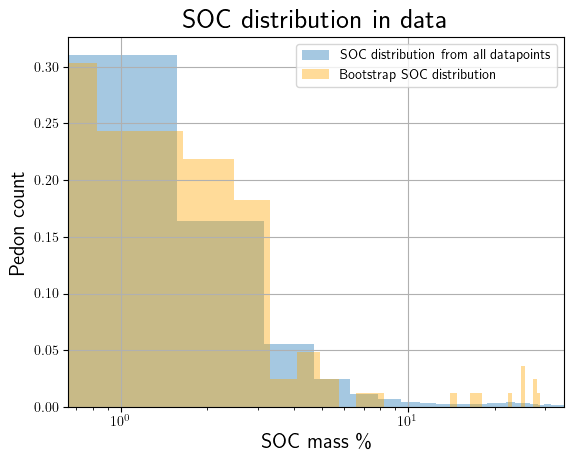

In [13]:
dataIndices = np.random.choice(NData,NPoints,replace=False)
msoc = sample_soc[dataIndices]

plt.hist(sample_soc, bins=50, density=True, alpha=0.4, label='SOC distribution from all datapoints')
plt.hist(msoc, bins=50, density=True, alpha=0.4, color='orange', label='Bootstrap SOC distribution')
plt.xlabel("SOC mass \%",fontsize=15)
plt.ylabel("Pedon count",fontsize=15)
plt.title("SOC distribution in data",fontsize=20)
plt.xscale('log')
plt.xlim([0,35])
plt.legend()
plt.grid()

msoc=msoc/100.0

In [14]:
def gaus(mu, sigma, N=1) :
    return np.random.randn(N) * sigma + mu;

In [15]:
# generate seed alphas from seed M's, specified below from initial literature
seedMsDict = {}
def genSeedMs() :
    for endMem in endMemList :
        if "Coarse measure of average abundance" in endMemMap[endMem] :
            seedMsDict[endMem] = float(endMemMap[endMem]["Coarse measure of average abundance"])/100.
        else :
            print("\t - Mineral",endMem,"Does not have any abundance set in the JSON file.")

    # collect constant seeds from the definitions above
    seedMs = [seedMsDict[x] if x in seedMsDict else 0.0 for x in endMemList]
    seedMs = seedMs + [0.0]

    # make seedMs an N x K matrix
    seedMs = np.ones([NPoints,KEndmembers]) * seedMs
    seedMs[:,KEndmembers-1] = msoc
    seedMrem = 1.0 - np.sum(seedMs,axis=1)

    # if seedM remainder is < 0, SOC exceeds pre-defined content,
    # so rescale pre-defined values, fix SOC to prior value, and set rest to 0
    seedMNegRem = (seedMs.T * (seedMrem < 0.0).astype('float32') / np.sum(seedMs[:,:-1],axis=1) * (1.0 - msoc)).T
    seedMNegRem[:,-1] = msoc * (seedMrem < 0.0).astype('float32')
    seedMs = (seedMs.T * (seedMrem >= 0.0).astype('float32')).T + seedMNegRem
    
    # get seeds that haven't been filled in yet, excluding SOC
    # if remaining mass fraction is < 0, exclude from further partitioning
    seedMZeros = ((seedMs == 0.0).astype('float32').T * (seedMrem > 0.0).astype('float32')).T
    
    # sample random remaining seeds and renormalize to the appropriate remainder
    seedMZeros = seedMZeros * np.random.random([NPoints,KEndmembers])
    seedMZeros[:,-1] = 0.0
    
    seedMZeros = (seedMZeros.T / (np.sum(seedMZeros,axis=1)+0.00000000001)).T
    seedMrem = 1.0 - np.sum(seedMs,axis=1)
    seedMZeros = (seedMZeros.T * seedMrem).T
    seedMZeros[:,-1] = 0.0

    # add remaining seeds into seedMs
    seedMs = seedMs + seedMZeros 

    del seedMZeros, seedMrem
    
    return seedMs

seedMs = genSeedMs()

### Generate SOC seed F

In [13]:
def fakeTrough(x,mu,sigma) :
    return 0.1*np.exp(-(x-mu)**2/2.0/sigma)

organicTroughs = [1650,1100,825,2060,1500,1000,751,1706,1754,1138,1170,853,877,1930,1449,2033,1524,2275,1706,1961,2137,2381,1400,1900,1791,2388]

tFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
trueFsoc = tFsoc - 0.125*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000).T,axis=0)
seedFsoc = tFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

F = [endMemMap[x]["Postprocessed Reflectance"] for x in endMemList]
F = np.array(F + [seedFsoc])

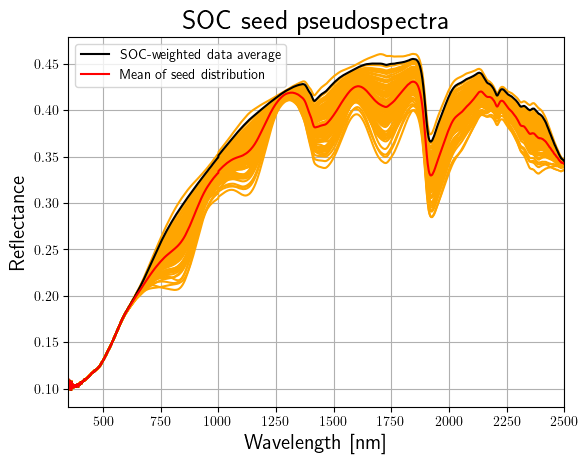

In [14]:
# Generate many seeds for comparison
seedFsocs = np.tile(tFsoc,(100,1))

for i in range(seedFsocs.shape[0]) :
    seedFsocs[i,:] = seedFsocs[i,:] - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)
    
plt.plot(XF,seedFsocs.T, 'orange')
plt.plot(XF,tFsoc.T, 'black',label="SOC-weighted data average")

plt.plot(XF,trueFsoc.T, 'red', label="Mean of seed distribution")

plt.legend()

plt.xlim([350,2500])

plt.xlabel("Wavelength [nm]",fontsize=15)
plt.ylabel("Reflectance",fontsize=15)
plt.title("SOC seed pseudospectra",fontsize=20)
plt.grid()

#plt.ylim([0,1.1])

### Generate reflectance pseudodata from mixing model

In [15]:
def A(ms,rhorads) :
    tA = ms / rhorads
    return (tA.T / np.sum(tA,axis=1)).T

def torchA(ms,rhorads) :
    tA = ms / rhorads
    return (tA.t() / torch.sum(tA,axis=1)).t()

rhorads = np.array(rhos)*np.array(rads)
trueSOCrr = np.mean(rhorads)
seedSOCrr = (np.mean(rhorads)*gaus(1.0,0.2))
seedAs = A(seedMs,np.append(rhorads,seedSOCrr))

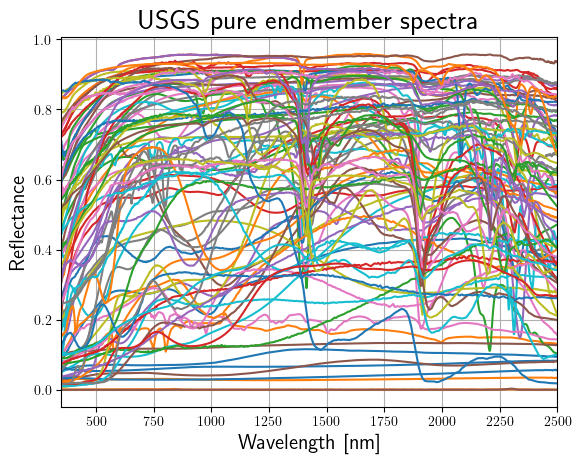

In [16]:
plt.plot(XF,F.T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'USGS pure endmember spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

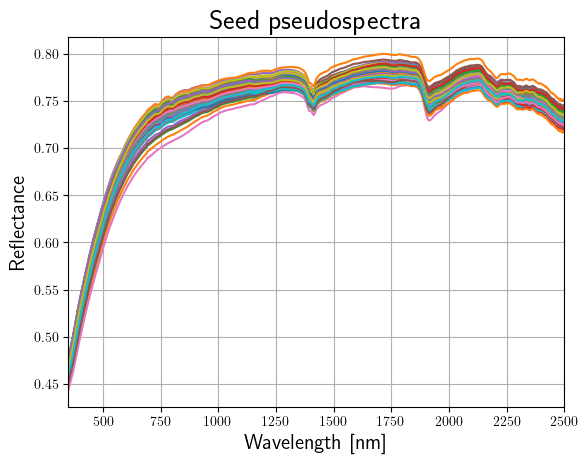

In [17]:
plt.plot(XF,np.dot(seedAs,F).T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'Seed pseudospectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()
#plt.plot(XF,maxI.T,'b');

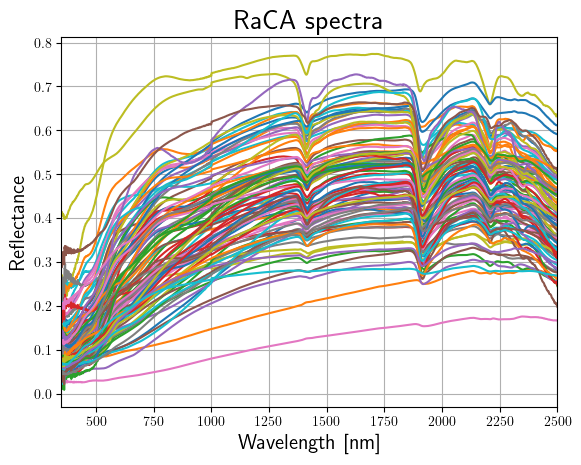

In [18]:
plt.plot(XF,dataI[dataIndices].T);
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'RaCA spectra',fontsize=20)
plt.xlim([350,2500])
plt.grid()

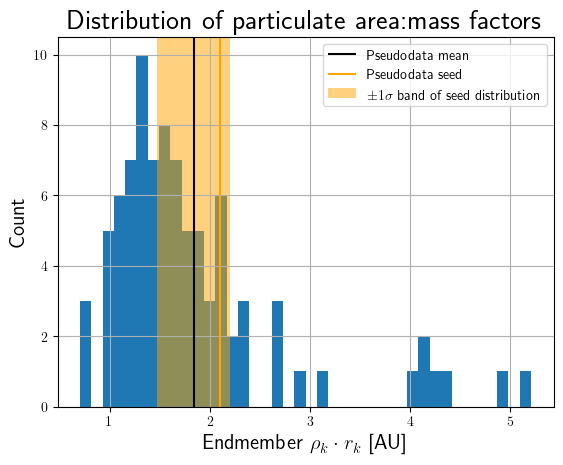

In [19]:
f, ax = plt.subplots()
th = plt.hist(rhorads,bins=40);
plt.xlabel(r'Endmember $\rho_k \cdot r_k$ [AU]',fontsize=15)
plt.ylabel(r'Count',fontsize=15)
plt.title(r'Distribution of particulate area:mass factors',fontsize=20)
plt.grid()

plt.vlines(trueSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='black',label=r'Pseudodata mean');
plt.vlines(seedSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='orange',label=r'Pseudodata seed');
ax.add_patch(Rectangle((trueSOCrr*0.8,0),trueSOCrr*0.4,np.max(th[0])*1.05,facecolor="orange",alpha=0.5,label=r'$\pm1\sigma$ band of seed distribution'));
plt.ylim([0,np.max(th[0])*1.05])
plt.legend()
plt.show()

### Run fit

In [10]:
class LinearMixingModel(nn.Module):
    def __init__(self, seedFs, seedFsoc, seedMs, rhorad, seedrrsoc, nepochs):
        super().__init__()
        # fixed quantities
        self.rhorad = rhorad
        self.fs     = seedFs
        
        # model parameters
        self.fsoc   = nn.Parameter(seedFsoc)
        self.rrsoc  = nn.Parameter(seedrrsoc)
        self.ms     = nn.Parameter(seedMs)
        
        # model output
        self.Ihat   = 0;
        
        # variables for tracking optimization
        self.epoch = 0;
        self.nepochs = nepochs;
        
        self.lsq = np.zeros(nepochs);
        self.loss = np.zeros(nepochs);
        self.bdsALoss = np.zeros(nepochs);
        self.bdsFLoss = np.zeros(nepochs);
        self.omrsLoss = np.zeros(nepochs);
        self.diffloss1 = np.zeros(nepochs);
        self.difflossfull = np.zeros(nepochs);
        
        
    def forward(self, y):
        msocs,Is,Imax = y
        rrFull    = torch.cat((self.rhorad,self.rrsoc))
        mFull     = torch.cat((self.ms,msocs.unsqueeze(1)),dim=1)
        mFull     = (mFull.t() / torch.sum(mFull,axis=1)).t()
        fFull     = torch.cat((self.fs,self.fsoc.unsqueeze(0)),dim=0)
        self.Ihat = torch.matmul(torchA(mFull,rrFull).float(),fFull.float())
                
        # Add in a fake Lagrange multiplier to discourage abundances < 0.001 or > 0.999
        oobsA = torch.sum((mFull < 0.001).float() * (mFull - 0.001)**2) 
        oobsA = oobsA + torch.sum((mFull > 0.999).float() * (mFull + 0.001 - 1.0) **2)

        # Add in a fake Lagrange multiplier to discourage Fsoc < 0 and Fsoc > 1
        oobsF = 1.0 * torch.sum((self.fsoc < 0.0).float() * (self.fsoc ** 2)) 
        oobsF = oobsF + 1.0 * torch.sum((self.fsoc > 1.0).float() * (1.0 - self.fsoc) **2)
        
        # Add in 1st derivative loss to smooth the curves
        diffloss = torch.sum(torch.diff(self.fsoc) ** 2)
        self.diffloss1[self.epoch] = diffloss.detach().item();
        
        diffloss += torch.sum(torch.diff(torch.diff(self.fsoc)) ** 2)
        
        # Compute the loss function, which is the mean-squared error between data and prediction,
        # with a multiplicative factor for our fake Lagrange multipliers
        lsq = torch.sum((Is - self.Ihat) ** 2)
        loss = lsq * (1 + 100.0* diffloss + 100.0*oobsA + 1000.0*oobsF) # + 10000.0*omrs
        
        # Report optimization statistics
        self.lsq[self.epoch]  = lsq.detach().item()
        self.loss[self.epoch] = loss.detach().item();
        self.bdsALoss[self.epoch] = oobsA.detach().item();
        self.bdsFLoss[self.epoch] = oobsF.detach().item();
        self.difflossfull[self.epoch] = diffloss.detach().item();
        
        self.epoch += 1;
        
        return loss
    

In [114]:
# seed data: A[1:,:] and initial F's
tF       = torch.tensor(F[:-1,:].tolist())
tFsoc    = torch.tensor(seedFsoc.tolist())
tseedMs  = torch.tensor(seedMs[:,:-1].tolist())
tmsoc    = torch.tensor(msoc.tolist())
trhorads = torch.tensor(rhorads.tolist())
trrsoc   = torch.tensor(seedSOCrr)

# empirical data: (SOC values, reflectances, and max normalized reflectance)
ys = (tmsoc,torch.tensor(dataI[dataIndices].tolist()),torch.tensor([]))

nepochs = 200000
model = LinearMixingModel(tF,tFsoc,tseedMs,trhorads,trrsoc,nepochs)
optimizer = optim.Adam(model.parameters(), lr = 0.00002, betas=(0.99,0.999))

for epoch in tqdm(range(nepochs)) :
    loss = model(ys)
    e = torch.mean(loss)
    e.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Epoch ",epoch,": ", loss.detach().item(), model.lsq[-1], model.lsq[-1] / (0.01 ** 2) / (NPoints*MSpectra))

  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch  199999 :  9.616293907165527 3.5281753540039062 0.16402488861013045


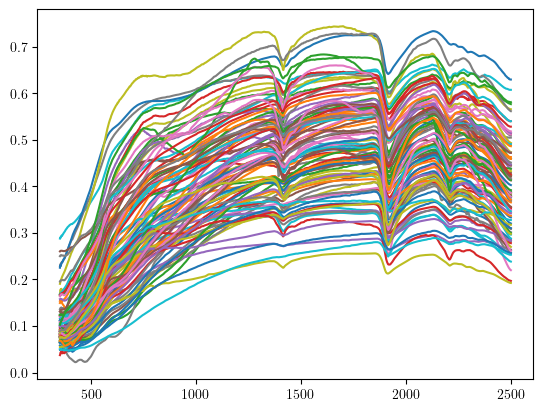

In [115]:
plt.plot(XF,model.Ihat.detach().numpy().T);

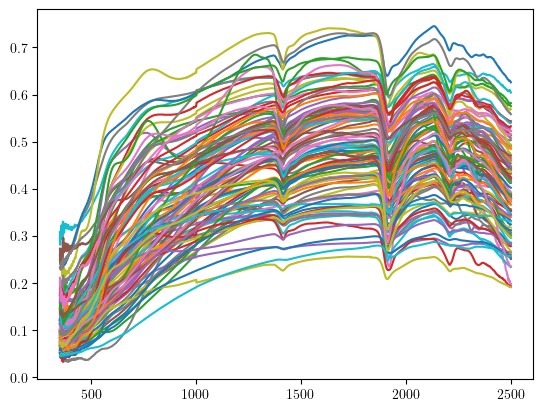

In [116]:
plt.plot(XF,dataI[dataIndices].T);

3.3138702610611026 1.4631021442766718 1.8363792196655018


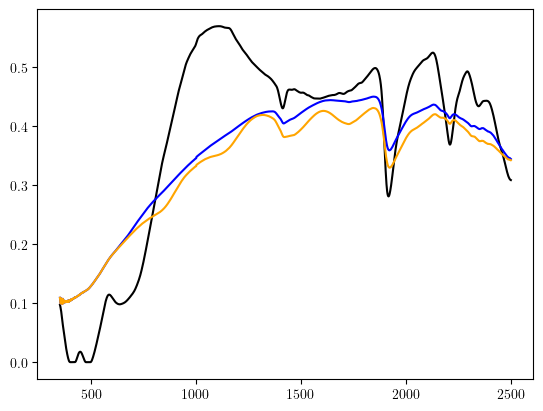

In [117]:
plt.plot(XF,model.fsoc.detach().numpy(),'black')
plt.plot(XF,seedFsoc,'blue')
plt.plot(XF,trueFsoc,'orange')
print(model.rrsoc.detach().item(),seedSOCrr[0],trueSOCrr)

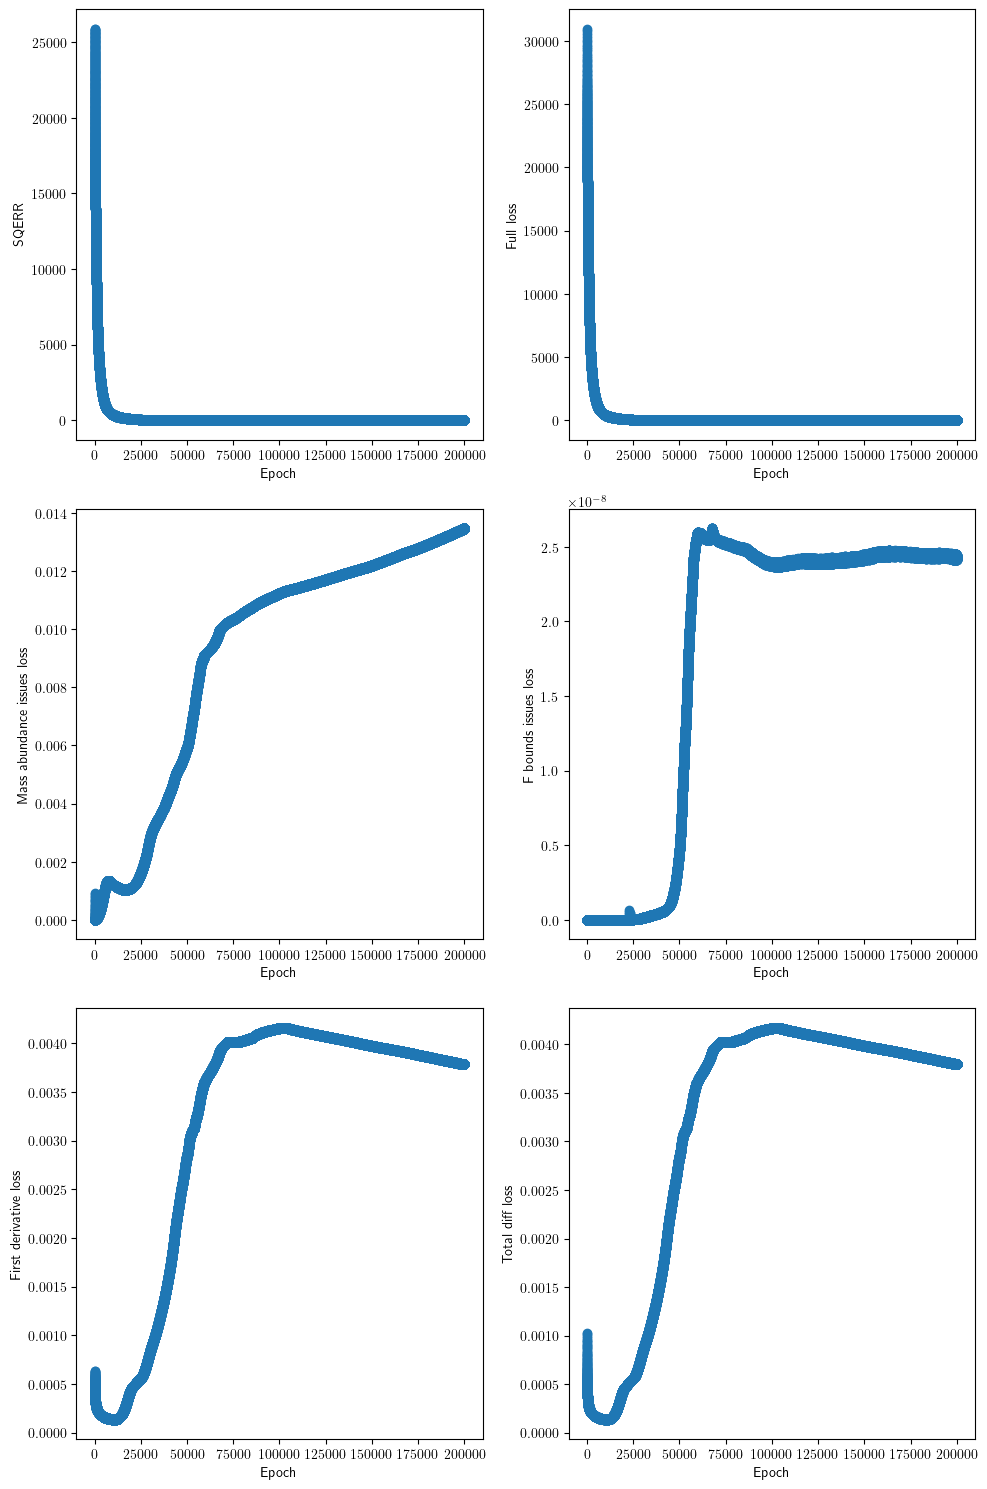

In [118]:
_, axarr = plt.subplots(3,2,figsize=(10,15))

axarr[0,0].scatter([i for i in range(len(model.lsq))],model.lsq)
axarr[0,0].set_xlabel("Epoch")
axarr[0,0].set_ylabel("SQERR")

axarr[0,1].scatter([i for i in range(len(model.loss))],model.loss)
axarr[0,1].set_xlabel("Epoch")
axarr[0,1].set_ylabel("Full loss")

axarr[1,0].scatter([i for i in range(len(model.bdsALoss))],model.bdsALoss)
axarr[1,0].set_xlabel("Epoch")
axarr[1,0].set_ylabel("Mass abundance issues loss")

axarr[1,1].scatter([i for i in range(len(model.bdsFLoss))],model.bdsFLoss)
axarr[1,1].set_xlabel("Epoch")
axarr[1,1].set_ylabel("F bounds issues loss")

axarr[2,0].scatter([i for i in range(len(model.diffloss1))],model.diffloss1)
axarr[2,0].set_xlabel("Epoch")
axarr[2,0].set_ylabel("First derivative loss")

axarr[2,1].scatter([i for i in range(len(model.difflossfull))],model.difflossfull)
axarr[2,1].set_xlabel("Epoch")
axarr[2,1].set_ylabel("Total diff loss")

plt.tight_layout()
plt.show()

  0%|          | 0/89 [00:00<?, ?it/s]

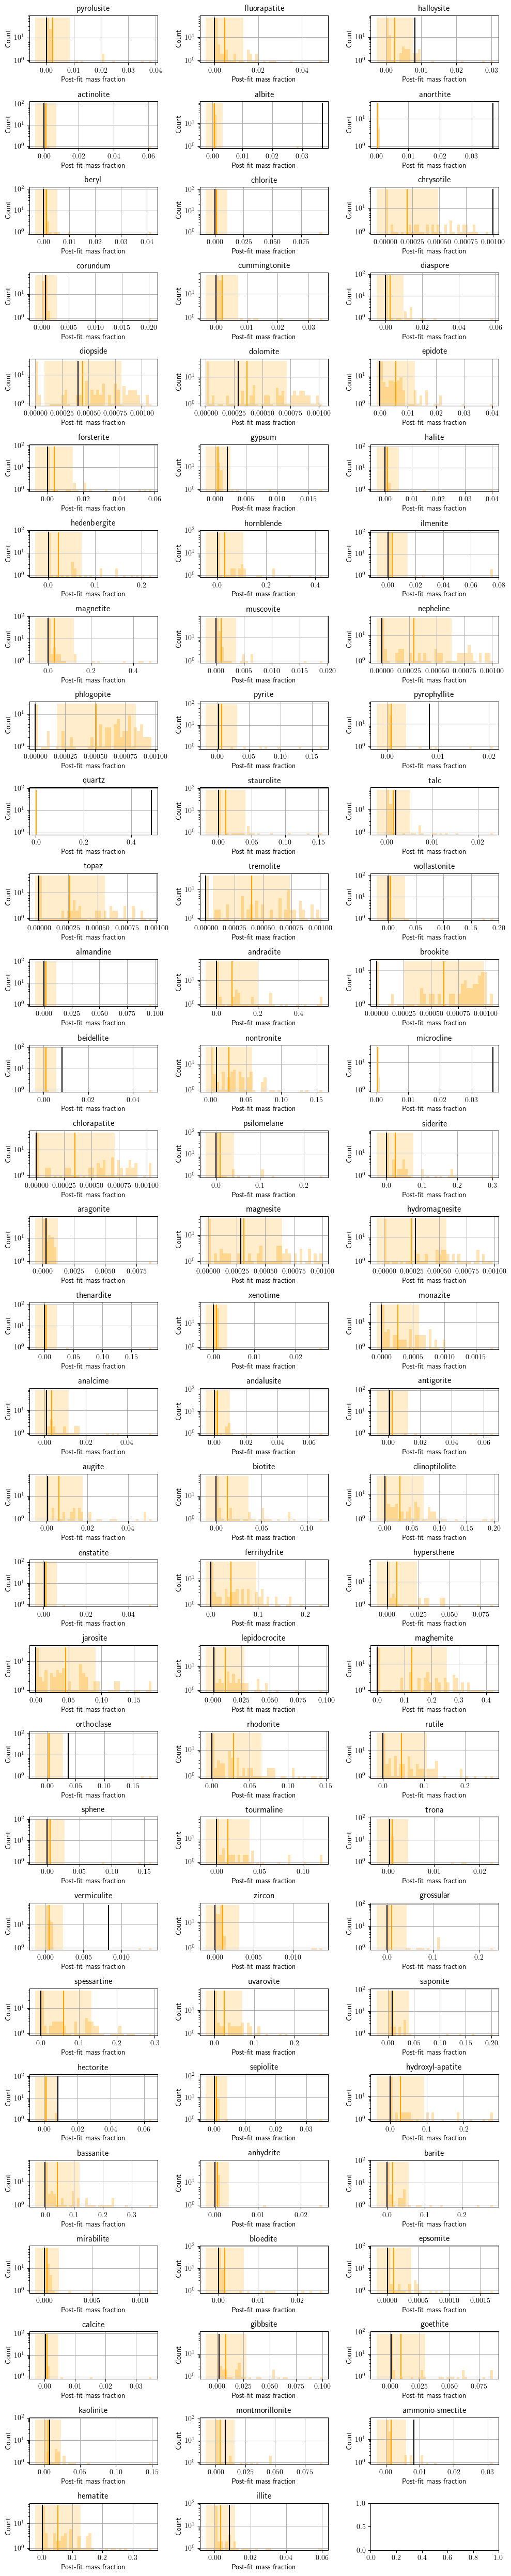

In [94]:
f, axarr = plt.subplots(int(np.ceil(KEndmembers/3.)),3,figsize=(10,50))

curr_row = 0
index = 0

for iEndmember in tqdm(range(model.ms.detach().numpy().shape[1])):

    col = index % 3
    
    tcorrms = np.array(model.ms.tolist())
    tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
    tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T 
    
    # plot endmember distribution histogram
    th = axarr[curr_row,col].hist(tcorrms[:,iEndmember],bins=40,color='orange',alpha=0.3)
    
    # add mean and standard deviation bar overlay
    avg = np.mean(tcorrms[:,iEndmember])
    sd = np.sqrt(np.var(tcorrms[:,iEndmember]))
    axarr[curr_row,col].add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="orange",alpha=0.2));
    axarr[curr_row,col].vlines(avg, ymin=0,ymax=np.max(th[0])*1.05,color='orange')
    
    # style
    axarr[curr_row,col].set_title(endMemList[iEndmember])
    axarr[curr_row,col].set_xlabel("Post-fit mass fraction")
    axarr[curr_row,col].set_ylabel("Count")
    axarr[curr_row,col].grid()
    axarr[curr_row,col].set_yscale('log')
    
    if endMemList[iEndmember] in seedMsDict :
        axarr[curr_row,col].vlines(seedMsDict[endMemList[iEndmember]],ymin=0,ymax=np.max(th[0]*1.05),color="black")

    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()

In [95]:
import pickle

with open('step2_systematics_N100_NpAll_E100k_init.pkl', 'wb') as file:
        pickle.dump((model,optimizer,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr), file)

In [119]:
import pickle

with open('step2_systematics_N100_NpAll_E100k_init.pkl', 'rb') as file:
        (model,optimizer,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)

## Serialize analysis

In [21]:
import pickle

offset = 738

for i in tqdm(range(762)) :
    
    # generate msoc
    dataIndices = np.random.choice(NData,NPoints,replace=False)
    msoc = sample_soc[dataIndices]/100.0
    
    # generate new seed Fsoc
    tempFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
    seedFsoc = tempFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

    # generate new seedMs
    seedMs = genSeedMs()
    
    # generate new seedSOCrr
    seedSOCrr = (np.mean(rhorads)*gaus(1.0,0.2))
    
    # convert to torch
    tF       = torch.tensor(F[:-1,:].tolist())
    tFsoc    = torch.tensor(seedFsoc.tolist())
    tseedMs  = torch.tensor(seedMs[:,:-1].tolist())
    tmsoc    = torch.tensor(msoc.tolist())
    trhorads = torch.tensor(rhorads.tolist())
    trrsoc   = torch.tensor(seedSOCrr)
    
    # empirical data: (SOC values, reflectances, and max normalized reflectance)
    ys = (tmsoc,torch.tensor(dataI[dataIndices].tolist()),torch.tensor([]))
    
    # run model fit
    nepochs=100000
    model = LinearMixingModel(tF,tFsoc,tseedMs,trhorads,trrsoc,nepochs)
    optimizer = optim.Adam(model.parameters(), lr = 0.00002, betas=(0.95,0.9))

    print("\t - Training model",i+offset)
    for epoch in tqdm(range(nepochs)) :
        loss = model(ys)
        e = torch.mean(loss)
        e.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Epoch ",epoch,": ", loss.detach().item(), model.lsq[-1], model.lsq[-1] / (0.05 ** 2) / (NPoints*MSpectra))
    
    with open('step2_systematics_N100_NpAll_E100k_%i.pkl'%(i+offset), 'wb') as file:
        pickle.dump((model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr), file)
        

  0%|          | 0/762 [00:00<?, ?it/s]

	 - Training model 738


  0%|          | 0/100000 [00:00<?, ?it/s]

/home/ecol/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch  99999 :  10.826647758483887 4.748260498046875 0.008829866105154576
	 - Training model 739


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.598530769348145 5.255332946777344 0.009772818125108959
	 - Training model 740


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.818004608154297 2.789011240005493 0.005186445820558796
	 - Training model 741


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.837000846862793 6.573540687561035 0.012224157485004248
	 - Training model 742


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.750006198883057 3.0238921642303467 0.005623230430925795
	 - Training model 743


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.744905948638916 2.216691493988037 0.004122159914436144
	 - Training model 744


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.302481651306152 1.6241755485534668 0.0030203171521217416
	 - Training model 745


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.916999816894531 3.7105839252471924 0.0069002025574099336
	 - Training model 746


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.255684852600098 2.4772286415100098 0.004606654842417498
	 - Training model 747


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.312575340270996 3.5157573223114014 0.006537902970360578
	 - Training model 748


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.086795806884766 2.864163398742676 0.005326198788921758
	 - Training model 749


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  118.1026840209961 107.54777526855469 0.19999586288899054
	 - Training model 750


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.596938133239746 2.562138080596924 0.0047645524511332835
	 - Training model 751


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.933915138244629 3.7807090282440186 0.007030607211983297
	 - Training model 752


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.4282917976379395 2.690670967102051 0.005003572230780196
	 - Training model 753


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.58824634552002 5.23272180557251 0.009730770442719682
	 - Training model 754


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.873453140258789 4.120273590087891 0.007662061534333593
	 - Training model 755


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.55624771118164 2.353466510772705 0.004376506761083598
	 - Training model 756


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.250508308410645 4.014449119567871 0.007465270329275445
	 - Training model 757


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.409671783447266 4.9174113273620605 0.009144419018804388
	 - Training model 758


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.075572967529297 2.9686079025268555 0.00552042380758132
	 - Training model 759


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.842363357543945 4.554516792297363 0.008469580273914201
	 - Training model 760


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.688087463378906 3.073962450027466 0.005716341143705189
	 - Training model 761


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.069258689880371 6.141773223876953 0.011421242629245843
	 - Training model 762


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  117.31910705566406 106.35177612304688 0.1977717826555962
	 - Training model 763


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.261089324951172 4.1895976066589355 0.007790976488440605
	 - Training model 764


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.4485502243042 3.2637596130371094 0.006069287983332606
	 - Training model 765


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.925220966339111 2.365388870239258 0.004398677582964681
	 - Training model 766


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.204357147216797 2.2933170795440674 0.004264652867585433
	 - Training model 767


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.162583351135254 3.479067325592041 0.006469674245638383
	 - Training model 768


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.992471218109131 3.3723325729370117 0.0062711902797526935
	 - Training model 769


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.46100378036499 3.161527633666992 0.005879177375484875
	 - Training model 770


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.23452377319336 2.232402801513672 0.004151376664832489
	 - Training model 771


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.424112319946289 5.980846881866455 0.011121983973717255
	 - Training model 772


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.457559585571289 3.819040298461914 0.007101888049208579
	 - Training model 773


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.124815940856934 2.5750010013580322 0.00478847234097263
	 - Training model 774


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.870792865753174 2.8568224906921387 0.005312547634945863
	 - Training model 775


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.244387626647949 2.902740478515625 0.005397936733641329
	 - Training model 776


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.974705696105957 5.649511337280273 0.010505832333389628
	 - Training model 777


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.067471504211426 3.9302377700805664 0.007308670888108909
	 - Training model 778


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.884735107421875 2.6378841400146484 0.0049054098373122225
	 - Training model 779


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.176507949829102 2.947357654571533 0.005480906842531906
	 - Training model 780


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.769340991973877 2.992396116256714 0.005564660374257021
	 - Training model 781


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.360179901123047 3.568418025970459 0.006635830824677747
	 - Training model 782


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.229227066040039 3.7513673305511475 0.006976043385497252
	 - Training model 783


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.468701362609863 3.6306774616241455 0.006751608482797108
	 - Training model 784


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.677765846252441 4.896054267883301 0.009104703427026127
	 - Training model 785


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.45280647277832 3.85323429107666 0.007165475204233677
	 - Training model 786


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.366476058959961 6.653985023498535 0.012373751787073053
	 - Training model 787


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.76273536682129 8.82182788848877 0.01640507278194099
	 - Training model 788


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.1423869132995605 2.3166089057922363 0.004307966352007877
	 - Training model 789


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.874483585357666 4.321393966674805 0.008036065024034969
	 - Training model 790


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.469409942626953 4.399790287017822 0.008181850835923423
	 - Training model 791


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.360610008239746 2.6918652057647705 0.00500579303721947
	 - Training model 792


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.317898750305176 3.174701452255249 0.005903675410981401
	 - Training model 793


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.053298950195312 3.4442293643951416 0.006404889566518161
	 - Training model 794


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.333147048950195 4.419607639312744 0.008218703187936296
	 - Training model 795


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.345151901245117 4.271970748901367 0.007944157599072741
	 - Training model 796


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.711410522460938 4.118443965911865 0.00765865916487562
	 - Training model 797


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.403133392333984 6.114899158477783 0.011371267612232045
	 - Training model 798


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.609506607055664 5.7929911613464355 0.010772647440904573
	 - Training model 799


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.3865647315979 2.5136966705322266 0.004674470795968807
	 - Training model 800


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.7715606689453125 2.9315578937530518 0.005451525604375735
	 - Training model 801


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.31810188293457 5.937081813812256 0.011040598445025113
	 - Training model 802


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.325136184692383 2.1627986431121826 0.00402194075892549
	 - Training model 803


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.884594917297363 3.8692007064819336 0.007195166353290438
	 - Training model 804


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.899253845214844 3.239502429962158 0.00602417932117556
	 - Training model 805


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.783466339111328 5.586726665496826 0.010389077946065691
	 - Training model 806


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.1974263191223145 2.6193768978118896 0.004870993766270365
	 - Training model 807


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.496548652648926 4.705946445465088 0.008751178885104764
	 - Training model 808


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.994813919067383 4.230956077575684 0.007867886708648412
	 - Training model 809


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.801360607147217 2.9769303798675537 0.005535900287991731
	 - Training model 810


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.602432250976562 5.843279838562012 0.010866164274406342
	 - Training model 811


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.871081352233887 7.2723798751831055 0.013523718968262398
	 - Training model 812


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.861988067626953 3.4582033157348633 0.006430875529028103
	 - Training model 813


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.93988037109375 4.2076802253723145 0.007824602929562647
	 - Training model 814


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.4925217628479 2.9205496311187744 0.005431054637133935
	 - Training model 815


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.390883445739746 2.816547393798828 0.005237652057273505
	 - Training model 816


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.18133544921875 3.7558913230895996 0.006984456202863039
	 - Training model 817


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.126276016235352 1.9137166738510132 0.003558747882568132
	 - Training model 818


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.644084930419922 3.623560905456543 0.00673837453362444
	 - Training model 819


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.649343490600586 2.7400898933410645 0.00509547167520421
	 - Training model 820


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.905640602111816 5.06881046295166 0.009425960879500993
	 - Training model 821


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.160941123962402 8.047736167907715 0.014965571674398352
	 - Training model 822


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.22728443145752 5.154876708984375 0.009586009686628311
	 - Training model 823


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.685346603393555 3.739513874053955 0.006954000695590803
	 - Training model 824


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.115383148193359 2.3929929733276367 0.00445001017820109
	 - Training model 825


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.560973167419434 2.8228087425231934 0.005249295662525696
	 - Training model 826


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.326663494110107 2.3830933570861816 0.004431600849997547
	 - Training model 827


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.471665382385254 4.393136024475098 0.008169476568061546
	 - Training model 828


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.177667617797852 4.895019054412842 0.009102778343863954
	 - Training model 829


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.676279544830322 2.718625068664551 0.005055555683244166
	 - Training model 830


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.00071144104004 6.352977275848389 0.011813997723567433
	 - Training model 831


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.758518218994141 2.28690242767334 0.0042527241797737595
	 - Training model 832


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.761809349060059 3.5641274452209473 0.006627852059918078
	 - Training model 833


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.520064353942871 5.605976581573486 0.010424875093581563
	 - Training model 834


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.644857406616211 6.104799270629883 0.011352485858911915
	 - Training model 835


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.853902816772461 3.354796886444092 0.006238580913889524
	 - Training model 836


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.78170394897461 4.3606977462768555 0.008109154339891874
	 - Training model 837


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.5017290115356445 1.4026155471801758 0.0026083041323666676
	 - Training model 838


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.841563701629639 1.977142095565796 0.0036766938085835343
	 - Training model 839


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  101.65258026123047 92.44757080078125 0.17191551985268477
	 - Training model 840


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.39375638961792 2.2584691047668457 0.004199849567209382
	 - Training model 841


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.24460220336914 9.75910758972168 0.01814803828865026
	 - Training model 842


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.535933494567871 6.523209571838379 0.012130561732846821
	 - Training model 843


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  107.47832489013672 100.01927185058594 0.18599585653293524
	 - Training model 844


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.837381362915039 1.9786580801010132 0.003679512933707137
	 - Training model 845


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.124438285827637 3.6234188079833984 0.006738110289136956
	 - Training model 846


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.984491348266602 6.674175262451172 0.012411297559183953
	 - Training model 847


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.319303512573242 8.8024320602417 0.01636900429612589
	 - Training model 848


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  21.66468620300293 8.43925666809082 0.015693643269346014
	 - Training model 849


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.952609062194824 2.804105758666992 0.005214515590268697
	 - Training model 850


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.561430931091309 5.667030334472656 0.010538410663826416
	 - Training model 851


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.370882034301758 2.22672176361084 0.004140812205691937
	 - Training model 852


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.641315460205078 3.1035566329956055 0.005771374491856076
	 - Training model 853


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.38359260559082 4.913806438446045 0.0091377153667058
	 - Training model 854


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.779011726379395 3.2483582496643066 0.006040647605140504
	 - Training model 855


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.344284057617188 4.040839672088623 0.007514346205650623
	 - Training model 856


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.840838432312012 2.727354049682617 0.0050717880979686035
	 - Training model 857


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.5171661376953125 1.9360229969024658 0.0036002287250626974
	 - Training model 858


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.241254806518555 5.204869747161865 0.009678976749719877
	 - Training model 859


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.052651405334473 4.928400993347168 0.009164855403713932
	 - Training model 860


/tmp/ipykernel_3302656/1588777146.py:2: RuntimeWarning: overflow encountered in exp
  return 0.1*np.exp(-(x-mu)**2/2.0/sigma)


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  nan nan nan
	 - Training model 861


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  112.41435241699219 103.8436279296875 0.19310762980880983
	 - Training model 862


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  101.53240966796875 89.76642608642578 0.1669296626432836
	 - Training model 863


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.758785247802734 2.0374443531036377 0.003788831897914714
	 - Training model 864


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.163646697998047 2.7917912006378174 0.005191615435867628
	 - Training model 865


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.7931976318359375 2.552539110183716 0.004746702203967858
	 - Training model 866


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.96939754486084 4.0606889724731445 0.007551257968336856
	 - Training model 867


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.484437942504883 5.3350701332092285 0.00992109741182562
	 - Training model 868


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.455378532409668 6.806116104125977 0.012656654772898141
	 - Training model 869


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.166247844696045 2.80692458152771 0.005219757473784676
	 - Training model 870


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.1755952835083 3.0840981006622314 0.005735189401510425
	 - Training model 871


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.095666885375977 4.151304721832275 0.007719767032696002
	 - Training model 872


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.751967430114746 6.417049884796143 0.011933147159081621
	 - Training model 873


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.670361518859863 5.70462703704834 0.01060832549892764
	 - Training model 874


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.188228607177734 5.46376895904541 0.01016042577228342
	 - Training model 875


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.067287445068359 1.6650185585021973 0.0030962688210175674
	 - Training model 876


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.209906578063965 2.6910409927368164 0.005004260330519416
	 - Training model 877


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.331850051879883 6.525254249572754 0.012134364015941892
	 - Training model 878


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  4.071837902069092 1.4539062976837158 0.0027036844215410794
	 - Training model 879


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.766448974609375 3.9873340129852295 0.007414847072032039
	 - Training model 880


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.239829063415527 3.3328943252563477 0.006197850907031794
	 - Training model 881


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.033533096313477 2.9811649322509766 0.005543774862391401
	 - Training model 882


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.688039779663086 4.9954352378845215 0.009289512297321284
	 - Training model 883


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.110994338989258 2.6049892902374268 0.004844238568549375
	 - Training model 884


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.376900672912598 7.591973304748535 0.01411803496931387
	 - Training model 885


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.546308517456055 6.88358736038208 0.012800720335438548
	 - Training model 886


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.648801326751709 2.686056137084961 0.004994990492022242
	 - Training model 887


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  114.9067153930664 106.06365966796875 0.1972360012421548
	 - Training model 888


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.811354637145996 3.9618353843688965 0.007367429817515381
	 - Training model 889


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.891698837280273 3.536752223968506 0.006576945093386342
	 - Training model 890


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.273530006408691 4.731725692749023 0.008799117978147879
	 - Training model 891


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.096882820129395 5.146949768066406 0.009571268745823161
	 - Training model 892


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.743943214416504 3.1584646701812744 0.005873481488017245
	 - Training model 893


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.981393814086914 3.60282826423645 0.006699820110156113
	 - Training model 894


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.924542427062988 5.603379249572754 0.01042004509451
	 - Training model 895


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.384250640869141 2.457956552505493 0.00457081646212086
	 - Training model 896


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.660682678222656 5.3880815505981445 0.010019677453460054
	 - Training model 897


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  110.31657409667969 95.1929931640625 0.17702090778998136
	 - Training model 898


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.99114418029785 7.110526084899902 0.013222735629753419
	 - Training model 899


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.337970733642578 4.479663372039795 0.008330382839683485
	 - Training model 900


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.019588470458984 2.478976249694824 0.0046099046949229635
	 - Training model 901


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.256117820739746 3.561920642852783 0.006623748289823863
	 - Training model 902


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.532408714294434 6.167864799499512 0.011469762528125543
	 - Training model 903


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.028409004211426 4.573461055755615 0.008504809029764042
	 - Training model 904


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.090717315673828 6.012423038482666 0.011180703000432664
	 - Training model 905


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.77617073059082 4.246356964111328 0.007896526200114044
	 - Training model 906


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.569053649902344 4.236534118652344 0.00787825963487186
	 - Training model 907


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  23.224712371826172 7.180420398712158 0.013352711108716239
	 - Training model 908


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.542340278625488 4.152243137359619 0.007721512110385157
	 - Training model 909


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.519551277160645 3.984673500061035 0.007409899581703458
	 - Training model 910


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.71843147277832 1.7413073778152466 0.003238135523598784
	 - Training model 911


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.346750259399414 2.550783157348633 0.0047434368337492
	 - Training model 912


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.711505889892578 2.556175708770752 0.0047534648233765716
	 - Training model 913


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.480868339538574 1.9189289808273315 0.0035684406895905743
	 - Training model 914


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.417693138122559 5.557941436767578 0.01033554892936788
	 - Training model 915


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.47874641418457 5.206817626953125 0.009682599027341933
	 - Training model 916


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.733451843261719 8.128911972045898 0.015116526214869173
	 - Training model 917


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.20612335205078 6.0950822830200195 0.011334416146945641
	 - Training model 918


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.78363037109375 3.5702197551727295 0.006639181320637339
	 - Training model 919


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.64297342300415 3.3177590370178223 0.0061697053222088735
	 - Training model 920


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.853351593017578 2.179605484008789 0.00405319476338222
	 - Training model 921


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.970292091369629 3.8253912925720215 0.007113698359036766
	 - Training model 922


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.71447467803955 3.597346782684326 0.006689626746042446
	 - Training model 923


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.414036750793457 2.136411428451538 0.003972871089635588
	 - Training model 924


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.793489456176758 3.2287955284118652 0.00600426876506158
	 - Training model 925


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  105.29764556884766 97.3683853149414 0.18106626743829174
	 - Training model 926


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.649235725402832 6.308297157287598 0.01173091056678307
	 - Training model 927


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.965668678283691 4.294158458709717 0.007985417868358375
	 - Training model 928


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.547951698303223 4.176966667175293 0.007767487991027973
	 - Training model 929


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.041497230529785 5.786469459533691 0.010760519683000819
	 - Training model 930


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.333409309387207 2.7272534370422363 0.005071600998683841
	 - Training model 931


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.110904693603516 3.24678897857666 0.006037729388334095
	 - Training model 932


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.57961654663086 3.086010694503784 0.005738746061373842
	 - Training model 933


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.600344181060791 2.167236804962158 0.004030193965527025
	 - Training model 934


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.920221328735352 1.920415997505188 0.0035712059460812416
	 - Training model 935


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.11384391784668 3.7409539222717285 0.006956678609524366
	 - Training model 936


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  18.418724060058594 9.876654624938965 0.018366628777199374
	 - Training model 937


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.050440788269043 4.655028343200684 0.008656491572665147
	 - Training model 938


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.289897441864014 2.7120628356933594 0.005043352553590626
	 - Training model 939


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.333038330078125 2.7400436401367188 0.005095385662736807
	 - Training model 940


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.060613632202148 3.4397754669189453 0.006396607097943179
	 - Training model 941


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.113120079040527 5.751107215881348 0.010694760048128957
	 - Training model 942


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.834704875946045 2.954883575439453 0.005494902046377411
	 - Training model 943


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.934303283691406 4.506031036376953 0.008379416153188195
	 - Training model 944


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.466005325317383 1.890082836151123 0.003514798393586467
	 - Training model 945


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.730161666870117 3.384676456451416 0.006294144967831549
	 - Training model 946


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.870343208312988 2.887284517288208 0.005369194825268633
	 - Training model 947


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.31505012512207 3.4681894779205322 0.006449445798085601
	 - Training model 948


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.814453601837158 2.525773525238037 0.004696928917225544
	 - Training model 949


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.3888726234436035 3.3740899562835693 0.006274458310150756
	 - Training model 950


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.728083610534668 4.280115127563477 0.00795930288714733
	 - Training model 951


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.501760482788086 5.782859802246094 0.01075380716363755
	 - Training model 952


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.63442325592041 3.3660342693328857 0.006259477953199229
	 - Training model 953


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.228644371032715 2.855112314224243 0.00530936739046814
	 - Training model 954


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.863182067871094 2.43770432472229 0.004533155415569111
	 - Training model 955


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.088034629821777 3.372678756713867 0.006271834043168511
	 - Training model 956


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.150562286376953 2.5941836833953857 0.004824144460056504
	 - Training model 957


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.958300590515137 4.217418193817139 0.007842711657493515
	 - Training model 958


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.466336250305176 2.2270116806030273 0.004141351335384522
	 - Training model 959


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.030866622924805 7.313629627227783 0.013600427014835485
	 - Training model 960


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.937410831451416 2.184741973876953 0.00406274658089624
	 - Training model 961


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.244996070861816 4.369348049163818 0.00812524044474908
	 - Training model 962


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.989628791809082 3.8382089138031006 0.007137534009861645
	 - Training model 963


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.923107147216797 5.524162292480469 0.01027273322637
	 - Training model 964


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.464316368103027 3.411963701248169 0.006344888333329927
	 - Training model 965


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.240425109863281 2.0686898231506348 0.003846935979824518
	 - Training model 966


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.717321395874023 3.836303472518921 0.007133990650895249
	 - Training model 967


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.781864166259766 7.047797203063965 0.013106084989426246
	 - Training model 968


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.30776309967041 3.1581859588623047 0.00587296319639666
	 - Training model 969


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.233759880065918 4.01834774017334 0.007472520204878362
	 - Training model 970


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.625261306762695 3.4479267597198486 0.006411765243551554
	 - Training model 971


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.959904670715332 2.281482458114624 0.004242645203374474
	 - Training model 972


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.7444915771484375 3.26809024810791 0.006077341233115592
	 - Training model 973


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.372441291809082 2.979194402694702 0.0055401104652621136
	 - Training model 974


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.725329399108887 4.6427741050720215 0.008633703589162288
	 - Training model 975


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.762295246124268 2.2049176692962646 0.004100265307849863
	 - Training model 976


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.943094253540039 1.708859920501709 0.0031777962259446
	 - Training model 977


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.082315444946289 2.7747490406036377 0.005159923831898907
	 - Training model 978


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.7405595779418945 2.6237666606903076 0.004879156970135392
	 - Training model 979


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.510329246520996 4.311996936798096 0.008018590305528768
	 - Training model 980


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.812441825866699 2.804577112197876 0.005215392119382381
	 - Training model 981


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.696319580078125 4.568469047546387 0.008495525890369848
	 - Training model 982


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.042603492736816 5.099087238311768 0.009482263576590919
	 - Training model 983


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.14737319946289 2.957794427871704 0.005500315068101727
	 - Training model 984


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.116644859313965 3.286932945251465 0.006112381116227735
	 - Training model 985


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.0784502029418945 1.9914817810058594 0.0037033598902944847
	 - Training model 986


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.004622459411621 5.262843132019043 0.009786784066981018
	 - Training model 987


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.759942054748535 2.3084161281585693 0.00429273106119678
	 - Training model 988


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.063750267028809 6.7401580810546875 0.012533999220929216
	 - Training model 989


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.044755935668945 2.6730849742889404 0.004970869315274644
	 - Training model 990


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.517016887664795 3.339097261428833 0.0062093858882916455
	 - Training model 991


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.795382499694824 6.128876686096191 0.011397260225190498
	 - Training model 992


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.942276954650879 4.237866401672363 0.00788073714862364
	 - Training model 993


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.135231018066406 4.403609275817871 0.008188952628206174
	 - Training model 994


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.610332012176514 2.983879327774048 0.005548822552810874
	 - Training model 995


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.796548843383789 4.286766052246094 0.00797167094792393
	 - Training model 996


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.708849906921387 2.1482608318328857 0.003994906242367058
	 - Training model 997


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.268278121948242 6.1712212562561035 0.011476004195734267
	 - Training model 998


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.119764804840088 2.013612985610962 0.0037445150824936524
	 - Training model 999


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.929631233215332 3.8522250652313232 0.007163598447664013
	 - Training model 1000


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.828628540039062 5.294909477233887 0.009846414648505598
	 - Training model 1001


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.921090126037598 7.95798397064209 0.014798668471672875
	 - Training model 1002


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.20993423461914 4.098848819732666 0.007622220027396868
	 - Training model 1003


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.120752334594727 4.068625450134277 0.007566016643671365
	 - Training model 1004


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.4581937789917 2.271214723587036 0.004223551322337584
	 - Training model 1005


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.910637855529785 2.2452218532562256 0.004175214975836773
	 - Training model 1006


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.071126937866211 5.3149094581604 0.00988360661675574
	 - Training model 1007


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.71662712097168 4.426623821258545 0.008231750481187437
	 - Training model 1008


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.341009140014648 4.396917343139648 0.008176508308953319
	 - Training model 1009


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.961582660675049 1.9773530960083008 0.003677086185045654
	 - Training model 1010


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.103028297424316 6.828986644744873 0.012699184834486047
	 - Training model 1011


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.831453800201416 2.6979737281799316 0.005017152446638645
	 - Training model 1012


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.202276229858398 4.68001127243042 0.00870294983250659
	 - Training model 1013


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.951597213745117 5.58583402633667 0.010387417994117468
	 - Training model 1014


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.683347702026367 2.469677209854126 0.004592612198705951
	 - Training model 1015


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.1151123046875 4.857746601104736 0.009033466482761014
	 - Training model 1016


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.239410400390625 8.100188255310059 0.015063111585885742
	 - Training model 1017


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.493914604187012 3.2258059978485107 0.005998709433470033
	 - Training model 1018


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.843321800231934 2.7034757137298584 0.005027383939990438
	 - Training model 1019


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.100154876708984 7.487146377563477 0.013923098796026918
	 - Training model 1020


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.670924186706543 2.876570224761963 0.005349270524894398
	 - Training model 1021


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.167675018310547 3.260913610458374 0.006063995556407947
	 - Training model 1022


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.741279602050781 3.8618733882904053 0.007181540471018884
	 - Training model 1023


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.427098274230957 4.677371025085449 0.008698040028052903
	 - Training model 1024


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.714405059814453 3.594176769256592 0.006683731788482736
	 - Training model 1025


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.99574089050293 3.7374727725982666 0.006950205062944242
	 - Training model 1026


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.520003318786621 2.9761109352111816 0.0055343764485563576
	 - Training model 1027


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.290984153747559 6.241944789886475 0.011607521692025054
	 - Training model 1028


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.563206672668457 2.083822011947632 0.003875075800925396
	 - Training model 1029


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.054972648620605 4.665106296539307 0.008675232536567747
	 - Training model 1030


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.909390449523926 4.524459362030029 0.008413685470999587
	 - Training model 1031


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.95570182800293 5.946195602416992 0.011057546448009282
	 - Training model 1032


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.073627471923828 5.773945331573486 0.010737229812317034
	 - Training model 1033


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.780908584594727 2.969768762588501 0.00552258254316783
	 - Training model 1034


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.954578399658203 2.369173049926758 0.0044057146442152625
	 - Training model 1035


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.601509094238281 5.564399242401123 0.010347557865924914
	 - Training model 1036


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.926894187927246 3.266752243041992 0.006074853078646195
	 - Training model 1037


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.118487358093262 3.3113341331481934 0.006157757569778136
	 - Training model 1038


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.828990936279297 4.660566329956055 0.00866679001386528
	 - Training model 1039


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.455709934234619 3.3224034309387207 0.006178342038007848
	 - Training model 1040


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.641616821289062 3.4071006774902344 0.006335845053445344
	 - Training model 1041


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.456087112426758 3.139186382293701 0.005837631580276523
	 - Training model 1042


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.391090393066406 3.987830638885498 0.007415770597648531
	 - Training model 1043


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.307564735412598 2.718067169189453 0.0050545182132765275
	 - Training model 1044


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.859358787536621 5.000871181488037 0.00929962097905725
	 - Training model 1045


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  nan nan nan
	 - Training model 1046


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.489324569702148 3.2081964015960693 0.005965962625004312
	 - Training model 1047


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.794887065887451 3.2933125495910645 0.006124244629644005
	 - Training model 1048


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.695951461791992 8.850767135620117 0.01645888821128799
	 - Training model 1049


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.399529457092285 8.66161823272705 0.016107146876293908
	 - Training model 1050


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.441100120544434 2.3819117546081543 0.004429403541809677
	 - Training model 1051


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.446151256561279 2.8947768211364746 0.005383127514898139
	 - Training model 1052


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.64681339263916 3.0189566612243652 0.005614052368618065
	 - Training model 1053


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.014937400817871 4.715905666351318 0.008769699054116814
	 - Training model 1054


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  19.9075984954834 9.670372009277344 0.017983025586754704
	 - Training model 1055


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.011552810668945 2.7976393699645996 0.005202490692635238
	 - Training model 1056


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.212018966674805 2.6766834259033203 0.004977560996565913
	 - Training model 1057


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.602951049804688 3.072936534881592 0.005714433351709142
	 - Training model 1058


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.836455345153809 4.174185752868652 0.007762316602266205
	 - Training model 1059


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.251924514770508 3.752501964569092 0.006978153351128017
	 - Training model 1060


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.926127433776855 4.579174995422363 0.008515434673030892
	 - Training model 1061


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.911619186401367 3.7845723628997803 0.007037791469827578
	 - Training model 1062


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.523005485534668 5.637063026428223 0.010482683452214266
	 - Training model 1063


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.498340606689453 4.062986373901367 0.007555530216460003
	 - Training model 1064


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.830279350280762 2.323024034500122 0.0043198959265460185
	 - Training model 1065


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.441709518432617 4.0290913581848145 0.007492499038930384
	 - Training model 1066


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.747959613800049 2.128868818283081 0.003958844850363702
	 - Training model 1067


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.539523124694824 2.488877773284912 0.004628317570032379
	 - Training model 1068


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.801081657409668 5.121118068695068 0.009523232112868558
	 - Training model 1069


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.169185638427734 3.6157267093658447 0.00672380606111733
	 - Training model 1070


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.802993774414062 5.4356889724731445 0.01010820822403188
	 - Training model 1071


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.207192420959473 5.26981258392334 0.009799744461038287
	 - Training model 1072


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.893349647521973 3.080754041671753 0.005728970788789869
	 - Training model 1073


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.856413841247559 2.8977067470550537 0.005388576005681178
	 - Training model 1074


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.986336708068848 3.095036745071411 0.005755530906687885
	 - Training model 1075


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.970535278320312 4.041387557983398 0.0075153650543624325
	 - Training model 1076


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.172320365905762 3.7172207832336426 0.006912544459755727
	 - Training model 1077


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.435220241546631 2.6902310848236084 0.005002754225613404
	 - Training model 1078


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.99360466003418 4.564403533935547 0.008487965660503107
	 - Training model 1079


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.063355445861816 5.815805435180664 0.010815072868769248
	 - Training model 1080


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.91792106628418 2.585491180419922 0.0048079798799068735
	 - Training model 1081


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.254261016845703 4.596380233764648 0.008547429537451691
	 - Training model 1082


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  150.26596069335938 141.80935668945312 0.26370870607057756
	 - Training model 1083


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.394775390625 2.832785129547119 0.005267847753690597
	 - Training model 1084


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.345633506774902 2.765179395675659 0.005142128118411266
	 - Training model 1085


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.4990234375 3.421192169189453 0.0063620495940296656
	 - Training model 1086


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.717449188232422 9.667166709899902 0.017977065011436356
	 - Training model 1087


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.917970657348633 9.544411659240723 0.017748789696403013
	 - Training model 1088


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.683964729309082 3.685182809829712 0.006852966638455995
	 - Training model 1089


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  114.54236602783203 90.11044311523438 0.1675693967740295
	 - Training model 1090


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.346234321594238 2.810985803604126 0.005227309723113204
	 - Training model 1091


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.400968551635742 4.951314449310303 0.009207465270683965
	 - Training model 1092


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  4.528355121612549 1.7592662572860718 0.0032715318592023645
	 - Training model 1093


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.781434059143066 3.6608800888061523 0.006807773293921249
	 - Training model 1094


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.789774894714355 2.7811686992645264 0.005171861830338495
	 - Training model 1095


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.647377967834473 4.051052570343018 0.007533338113143686
	 - Training model 1096


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.398401260375977 8.670027732849121 0.01612278518428474
	 - Training model 1097


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.093926429748535 5.323034286499023 0.009898715549045136
	 - Training model 1098


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.768258094787598 2.332263708114624 0.004337078025317756
	 - Training model 1099


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.521921157836914 9.812765121459961 0.018247819844648922
	 - Training model 1100


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.803260803222656 7.985631942749023 0.014850082645744346
	 - Training model 1101


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.925484657287598 3.243966817855835 0.006032481297732839
	 - Training model 1102


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.674374103546143 2.799121141433716 0.005205246195134757
	 - Training model 1103


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.983599662780762 3.3483386039733887 0.006226571090606022
	 - Training model 1104


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.019009590148926 3.985822916030884 0.007412037035854734
	 - Training model 1105


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  18.65755844116211 5.2538161277771 0.009769997448214038
	 - Training model 1106


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.602456092834473 2.862234354019165 0.005322611536995192
	 - Training model 1107


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.407536029815674 1.874849557876587 0.0034864705864743593
	 - Training model 1108


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.555850982666016 6.7173848152160645 0.012491650051540796
	 - Training model 1109


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.497012138366699 1.6057367324829102 0.0029860283263280518
	 - Training model 1110


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.8074369430542 5.787074565887451 0.010761644938888796
	 - Training model 1111


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.829534530639648 4.5234055519104 0.00841172580550516
	 - Training model 1112


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.181466102600098 1.5549147129058838 0.00289151968927175
	 - Training model 1113


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.389957427978516 3.1312689781188965 0.0058229083740007365
	 - Training model 1114


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.474845886230469 2.5501136779785156 0.004742191869788034
	 - Training model 1115


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  98.43742370605469 82.15623474121094 0.15277774940253078
	 - Training model 1116


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.046020984649658 1.77744722366333 0.0033053411876584468
	 - Training model 1117


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.171110153198242 3.5836939811706543 0.006664237993808747
	 - Training model 1118


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.537123680114746 2.1385021209716797 0.003976758941834829
	 - Training model 1119


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.076274871826172 3.005730390548706 0.005589456793210052
	 - Training model 1120


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.8433332443237305 2.0674922466278076 0.003844708966299967
	 - Training model 1121


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.548928260803223 4.929525375366211 0.009166946304725634
	 - Training model 1122


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.241182327270508 3.32251238822937 0.006178544655005801
	 - Training model 1123


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.910329818725586 2.375422716140747 0.0044173365246689845
	 - Training model 1124


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.1742525100708 7.844803810119629 0.014588198624118321
	 - Training model 1125


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.9330549240112305 2.3196475505828857 0.004313617016425635
	 - Training model 1126


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.454159736633301 2.5082459449768066 0.004664334625712331
	 - Training model 1127


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.406892776489258 8.559188842773438 0.015916669163688398
	 - Training model 1128


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.498878479003906 2.4584856033325195 0.00457180028513718
	 - Training model 1129


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.246047973632812 5.840534687042236 0.01086105939012968
	 - Training model 1130


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  109.0821304321289 99.48873138427734 0.18500926338312845
	 - Training model 1131


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.39087438583374 2.2857956886291504 0.004250666087641376
	 - Training model 1132


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.156830787658691 2.5980489253997803 0.0048313322648066565
	 - Training model 1133


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.285167694091797 2.6580309867858887 0.004942874917314529
	 - Training model 1134


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.353723526000977 9.01402473449707 0.016762482072518955
	 - Training model 1135


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.129039764404297 1.7508753538131714 0.0032559281335437862
	 - Training model 1136


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.597040176391602 3.4659156799316406 0.006445217442922622
	 - Training model 1137


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.795443058013916 2.474855899810791 0.004602242491512395
	 - Training model 1138


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.451701164245605 5.54801607131958 0.01031709171793506
	 - Training model 1139


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.445921897888184 3.9144670963287354 0.007279343740267289
	 - Training model 1140


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.791647911071777 5.7586870193481445 0.010708855452065352
	 - Training model 1141


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.152444362640381 1.7855485677719116 0.003320406448669291
	 - Training model 1142


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.740904808044434 7.537759304046631 0.014017218603526973
	 - Training model 1143


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.681699752807617 5.034268856048584 0.009361727300880675
	 - Training model 1144


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.278071403503418 3.4749324321746826 0.006461984997070539
	 - Training model 1145


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.514979362487793 7.107290267944336 0.013216718303941116
	 - Training model 1146


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.608016967773438 4.2663655281066895 0.007933734129440612
	 - Training model 1147


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.785194396972656 5.442722797393799 0.01012128832616234
	 - Training model 1148


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.187420845031738 2.5485291481018066 0.0047392452777346465
	 - Training model 1149


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.102675437927246 3.359623432159424 0.006247556359199299
	 - Training model 1150


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.456681251525879 2.9543285369873047 0.005493869896768581
	 - Training model 1151


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.344882488250732 2.9137396812438965 0.005418390853080234
	 - Training model 1152


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.802953720092773 3.690052032470703 0.006862021445784663
	 - Training model 1153


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.603464126586914 2.4296751022338867 0.004518224271936562
	 - Training model 1154


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.779973983764648 5.1960906982421875 0.009662651228716292
	 - Training model 1155


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.578299522399902 2.8950743675231934 0.0053836808322142125
	 - Training model 1156


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.295858383178711 4.257933616638184 0.00791805414530578
	 - Training model 1157


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.820930480957031 3.502455472946167 0.006513166848807376
	 - Training model 1158


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.539088249206543 6.104626655578613 0.011352164863930474
	 - Training model 1159


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.325892448425293 8.520565032958984 0.015844844319774957
	 - Training model 1160


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.029111862182617 4.089478492736816 0.007604794965572879
	 - Training model 1161


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.64696979522705 2.7518374919891357 0.005117317511834747
	 - Training model 1162


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.451504707336426 1.7779350280761719 0.0033062483088352797
	 - Training model 1163


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.068552017211914 2.871946334838867 0.005340671938333551
	 - Training model 1164


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.761910438537598 5.200993061065674 0.00967176766353449
	 - Training model 1165


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.129534721374512 3.7816460132598877 0.007032349629493049
	 - Training model 1166


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.919405937194824 5.034262657165527 0.00936171577343659
	 - Training model 1167


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.437451362609863 3.3954920768737793 0.006314257697580249
	 - Training model 1168


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  104.0636978149414 93.8973159790039 0.17461146625570226
	 - Training model 1169


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.9985246658325195 2.921302318572998 0.00543245433486378
	 - Training model 1170


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.58035945892334 5.311069965362549 0.009876466695234863
	 - Training model 1171


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.670929908752441 2.2194883823394775 0.004127361008534592
	 - Training model 1172


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.329017639160156 3.181155204772949 0.005915676810363456
	 - Training model 1173


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.794946670532227 4.980795860290527 0.009262288908025154
	 - Training model 1174


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.298516273498535 4.9616618156433105 0.009226707235041022
	 - Training model 1175


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.919729709625244 2.6062726974487305 0.004846625192838177
	 - Training model 1176


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.25432014465332 2.942594051361084 0.005472048445115915
	 - Training model 1177


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.438826560974121 4.6242876052856445 0.008599326090721792
	 - Training model 1178


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.258251190185547 2.3036296367645264 0.004283830100910322
	 - Training model 1179


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.74106502532959 2.9512510299682617 0.005488146964143675
	 - Training model 1180


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.249566078186035 4.008664608001709 0.007454513450491322
	 - Training model 1181


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.244731903076172 2.759355068206787 0.00513129719796706
	 - Training model 1182


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.5894269943237305 2.3204596042633057 0.004315127111600753
	 - Training model 1183


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.690997123718262 4.962857246398926 0.009228930258296466
	 - Training model 1184


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.277534484863281 3.059621572494507 0.005689672845178068
	 - Training model 1185


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.277854919433594 1.9721630811691284 0.0036674348324855937
	 - Training model 1186


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.793014526367188 2.9891836643218994 0.005558686498041653
	 - Training model 1187


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.95111083984375 3.8277788162231445 0.007118138198462378
	 - Training model 1188


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.85408878326416 3.8368496894836426 0.00713500639606442
	 - Training model 1189


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.201041221618652 4.014017581939697 0.007464467841821844
	 - Training model 1190


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.296631813049316 3.0417447090148926 0.005656429026526996
	 - Training model 1191


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.313542366027832 3.6089322566986084 0.0067111710956738405
	 - Training model 1192


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.508464813232422 3.897886037826538 0.007248509600793189
	 - Training model 1193


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.461957931518555 5.086711406707764 0.009459249477838704
	 - Training model 1194


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.000609397888184 2.262089252471924 0.004206581594554948
	 - Training model 1195


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.302993774414062 5.256850242614746 0.009775639688730348
	 - Training model 1196


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.715765953063965 4.5806427001953125 0.008518164017099603
	 - Training model 1197


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.626695156097412 2.646833896636963 0.004922052806391376
	 - Training model 1198


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  20.514556884765625 9.37628173828125 0.017436135264121334
	 - Training model 1199


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.249927520751953 7.598110675811768 0.014129448025684364
	 - Training model 1200


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.109037399291992 5.264894962310791 0.00979059965097311
	 - Training model 1201


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.664401054382324 4.314826488494873 0.008023852140390279
	 - Training model 1202


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.83681583404541 5.014794826507568 0.00932551339192481
	 - Training model 1203


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.141559600830078 4.842831134796143 0.009005729678839872
	 - Training model 1204


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.039000511169434 2.672236204147339 0.004969290942161485
	 - Training model 1205


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.861844062805176 2.630455732345581 0.004891595969029439
	 - Training model 1206


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.566764831542969 4.051014423370361 0.007533267175026241
	 - Training model 1207


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.067317962646484 4.750199317932129 0.008833471534973738
	 - Training model 1208


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.017582893371582 5.455589771270752 0.010145215753176664
	 - Training model 1209


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.726517200469971 1.959845781326294 0.003644529579407334
	 - Training model 1210


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.43592643737793 3.249749183654785 0.006043234186247856
	 - Training model 1211


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.777435302734375 2.11124324798584 0.003926068336561301
	 - Training model 1212


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.665806770324707 3.2093305587768555 0.0059680717039086095
	 - Training model 1213


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.753732204437256 1.9052118062973022 0.0035429322292836857
	 - Training model 1214


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.204252243041992 6.118786811828613 0.011378497093126197
	 - Training model 1215


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.437381744384766 6.2061767578125 0.011541007452928869
	 - Training model 1216


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.12026309967041 5.380767822265625 0.010006076842892838
	 - Training model 1217


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.0733003616333 4.216578483581543 0.00784115013218325
	 - Training model 1218


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  16.531890869140625 5.107884883880615 0.009498623679926758
	 - Training model 1219


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.794144153594971 2.4610180854797363 0.004576509689409086
	 - Training model 1220


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.9000043869018555 2.3875818252563477 0.004439947606241464
	 - Training model 1221


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.02390193939209 2.4126498699188232 0.004486564146757457
	 - Training model 1222


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.908818244934082 4.510875225067139 0.00838842440737729
	 - Training model 1223


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.41535472869873 3.170401096343994 0.005895678468329137
	 - Training model 1224


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.99460220336914 5.053915023803711 0.009398261318091511
	 - Training model 1225


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.500029563903809 2.1388988494873047 0.0039774966982562615
	 - Training model 1226


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.578871726989746 1.692444086074829 0.0031472693371916854
	 - Training model 1227


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  109.43155670166016 100.3726577758789 0.1866530130653257
	 - Training model 1228


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.645266532897949 2.3348381519317627 0.004341865461518851
	 - Training model 1229


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.217325210571289 4.046269416809082 0.007524443359942504
	 - Training model 1230


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.443530082702637 2.5705249309539795 0.0047801486396168835
	 - Training model 1231


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.06329345703125 3.872115135192871 0.0072005860254632644
	 - Training model 1232


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.850723743438721 2.9522979259490967 0.005490093772104316
	 - Training model 1233


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.582403182983398 3.7256171703338623 0.006928158382768688
	 - Training model 1234


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.475476264953613 3.590996265411377 0.006677817322940728
	 - Training model 1235


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.024874687194824 2.584047317504883 0.004805294872161566
	 - Training model 1236


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.684450149536133 3.8684823513031006 0.007193830499866295
	 - Training model 1237


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.982610702514648 2.236846923828125 0.004159640955514876
	 - Training model 1238


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.419939041137695 7.090120792388916 0.013184789944005421
	 - Training model 1239


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.758759498596191 2.217583179473877 0.0041238180929314295
	 - Training model 1240


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.732901096343994 3.588865041732788 0.006673854098991702
	 - Training model 1241


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.056329727172852 2.321937084197998 0.00431787463356206
	 - Training model 1242


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.695990562438965 3.901569128036499 0.00725535867603254
	 - Training model 1243


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.898784637451172 4.411762714385986 0.008204114764083654
	 - Training model 1244


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.756505966186523 5.7312493324279785 0.010657832324366298
	 - Training model 1245


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.809248924255371 2.576820135116577 0.004791855202448306
	 - Training model 1246


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.696100234985352 3.1483254432678223 0.005854626579763499
	 - Training model 1247


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.568364143371582 3.353274345397949 0.006235749596276985
	 - Training model 1248


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.49538803100586 3.035316228866577 0.005644474623647748
	 - Training model 1249


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.320894241333008 2.5340592861175537 0.0047123371196979135
	 - Training model 1250


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.906965255737305 5.325405120849609 0.009903124353044367
	 - Training model 1251


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.126864433288574 4.108860969543457 0.007640838623046874
	 - Training model 1252


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.304375648498535 6.059311389923096 0.011267896587490646
	 - Training model 1253


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.743349075317383 6.856860160827637 0.012751018430176914
	 - Training model 1254


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.248661041259766 2.48179292678833 0.004615142588169837
	 - Training model 1255


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.558799743652344 9.900379180908203 0.018410746965891588
	 - Training model 1256


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.310003757476807 1.9887089729309082 0.0036982035758826737
	 - Training model 1257


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.029419898986816 3.702266216278076 0.006884734944264204
	 - Training model 1258


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.614045143127441 2.4364805221557617 0.004530879632088817
	 - Training model 1259


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.378029823303223 2.10988450050354 0.003923541609490543
	 - Training model 1260


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.525875091552734 2.1931357383728027 0.004078355626913626
	 - Training model 1261


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.49082088470459 3.008267402648926 0.0055941746213834034
	 - Training model 1262


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.668479919433594 1.3722243309020996 0.002551788620924406
	 - Training model 1263


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.181357383728027 4.639371871948242 0.008627376795812628
	 - Training model 1264


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  17.10740852355957 6.80771541595459 0.012659628853472039
	 - Training model 1265


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.199247360229492 4.0581817626953125 0.007546595560567758
	 - Training model 1266


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.518226623535156 2.9272899627685547 0.005443588959123299
	 - Training model 1267


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.904734134674072 2.8533339500427246 0.005306060344105484
	 - Training model 1268


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.699329376220703 3.980482578277588 0.007402106142775615
	 - Training model 1269


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.552828788757324 4.497719764709473 0.008363960510849784
	 - Training model 1270


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.51851749420166 2.459965705871582 0.004574552684094061
	 - Training model 1271


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.472643852233887 3.7327144145965576 0.006941356419519399
	 - Training model 1272


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.198770523071289 4.69683837890625 0.008734241522838212
	 - Training model 1273


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.91389274597168 4.726878643035889 0.008790104403599976
	 - Training model 1274


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.851532936096191 4.006681442260742 0.0074508255551106305
	 - Training model 1275


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.5260701179504395 3.5347228050231934 0.006573171185538248
	 - Training model 1276


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.573700904846191 5.461404800415039 0.010156029382454742
	 - Training model 1277


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.727619171142578 4.288184642791748 0.00797430895916643
	 - Training model 1278


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.204725742340088 2.4585087299346924 0.004571843291370882
	 - Training model 1279


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.771533012390137 1.9416260719299316 0.003610648204425721
	 - Training model 1280


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.736311912536621 3.307192087173462 0.006150055020313271
	 - Training model 1281


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.403438091278076 1.4615263938903809 0.002717854753864027
	 - Training model 1282


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.466038227081299 2.5756547451019287 0.00478968804296035
	 - Training model 1283


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  112.12635803222656 107.30747985839844 0.19954900949957866
	 - Training model 1284


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.309998512268066 5.206303119659424 0.009681642249482888
	 - Training model 1285


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.850086212158203 2.448631525039673 0.004553475639311339
	 - Training model 1286


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.167032241821289 6.382219314575195 0.011868376224221653
	 - Training model 1287


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.952720642089844 2.0525922775268555 0.003817000980989038
	 - Training model 1288


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.84213638305664 5.197635650634766 0.00966552422247283
	 - Training model 1289


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.285486221313477 3.3732848167419434 0.006272961072509424
	 - Training model 1290


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.69199275970459 5.398584842681885 0.010039209377372169
	 - Training model 1291


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.242572784423828 6.789727210998535 0.012626177984190672
	 - Training model 1292


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.043971061706543 4.553837776184082 0.008468317575423675
	 - Training model 1293


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.655888557434082 6.134735107421875 0.011408154546577171
	 - Training model 1294


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.074653625488281 4.7389655113220215 0.008812581146112544
	 - Training model 1295


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.26543140411377 4.304287910461426 0.008004254598719526
	 - Training model 1296


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.494773864746094 5.062891960144043 0.009414954830579343
	 - Training model 1297


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.0025634765625 3.266995668411255 0.006075305752508144
	 - Training model 1298


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.68726921081543 6.777221202850342 0.012602921809112674
	 - Training model 1299


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.037436485290527 3.3768515586853027 0.006279593786490566
	 - Training model 1300


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.159533500671387 4.616694927215576 0.008585206745170758
	 - Training model 1301


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.434074401855469 2.4924585819244385 0.004634976442444329
	 - Training model 1302


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.53564453125 6.690116882324219 0.012440942598464375
	 - Training model 1303


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.98081111907959 4.361566543579102 0.008110769955516692
	 - Training model 1304


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.322566986083984 4.582421779632568 0.00852147239355196
	 - Training model 1305


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.79596996307373 3.044511318206787 0.005661573813494722
	 - Training model 1306


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.128239631652832 3.2830810546875 0.006105218139818688
	 - Training model 1307


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.973249435424805 2.8499414920806885 0.00529975172864842
	 - Training model 1308


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.050765514373779 3.4022598266601562 0.006326843006341526
	 - Training model 1309


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.220507621765137 3.377467155456543 0.006280738550360841
	 - Training model 1310


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.315031051635742 5.9799113273620605 0.011120244216386908
	 - Training model 1311


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.130946636199951 2.046868324279785 0.0038063567164663597
	 - Training model 1312


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.125614166259766 6.95624303817749 0.012935830847377943
	 - Training model 1313


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.904887199401855 4.63630485534668 0.00862167337117002
	 - Training model 1314


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.209671020507812 7.461363792419434 0.013875153495898527
	 - Training model 1315


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.799111366271973 7.507693767547607 0.013961308726262401
	 - Training model 1316


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.157547950744629 5.219063758850098 0.009705371936494834
	 - Training model 1317


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.540966510772705 2.8182260990142822 0.005240773777804336
	 - Training model 1318


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.169754981994629 2.422393560409546 0.004504683515405942
	 - Training model 1319


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.795226097106934 3.720949649810791 0.006919478660736012
	 - Training model 1320


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.7420806884765625 2.8244638442993164 0.005252373490096357
	 - Training model 1321


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.031763076782227 2.804565906524658 0.005215371281310381
	 - Training model 1322


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.662414073944092 2.1867032051086426 0.0040663936868594
	 - Training model 1323


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.822341918945312 2.85483980178833 0.00530886062629164
	 - Training model 1324


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.209554672241211 3.503828525543213 0.006515720177672176
	 - Training model 1325


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.893019676208496 3.746243715286255 0.0069665155095978695
	 - Training model 1326


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.277037620544434 3.422074317932129 0.006363690037995589
	 - Training model 1327


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.249403953552246 4.92120361328125 0.009151471154404926
	 - Training model 1328


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.754919052124023 4.531652927398682 0.008427062626496848
	 - Training model 1329


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.114175796508789 2.2056093215942383 0.004101551504591795
	 - Training model 1330


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.332751274108887 3.484066963195801 0.006478971572656068
	 - Training model 1331


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  3.890864133834839 1.0625760555267334 0.0019759666304541763
	 - Training model 1332


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.250978469848633 2.5493173599243164 0.004740711036586361
	 - Training model 1333


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  4.956244468688965 1.082666277885437 0.0020133264116883997
	 - Training model 1334


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.303211212158203 6.634949684143066 0.012338353666467811
	 - Training model 1335


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.898082733154297 4.456741809844971 0.008287757898363494
	 - Training model 1336


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.040593147277832 1.6879923343658447 0.00313899085888581
	 - Training model 1337


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.153382301330566 5.89459228515625 0.010961584909635051
	 - Training model 1338


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.9542927742004395 2.417067766189575 0.0044947796674841
	 - Training model 1339


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  101.75836181640625 85.55073547363281 0.1590901635957839
	 - Training model 1340


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.870017051696777 4.395172119140625 0.008173262890080192
	 - Training model 1341


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  18.872943878173828 6.512862205505371 0.012111319768489762
	 - Training model 1342


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.676126480102539 4.249382019042969 0.007902151592827462
	 - Training model 1343


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.265694618225098 4.184569358825684 0.007781625957834836
	 - Training model 1344


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.996240139007568 2.3857104778289795 0.004436467648217534
	 - Training model 1345


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.694537162780762 2.289095163345337 0.004256801791437167
	 - Training model 1346


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.683881759643555 5.331040382385254 0.009913603686443985
	 - Training model 1347


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.729223251342773 4.114317417144775 0.007650985434020967
	 - Training model 1348


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.718996047973633 5.102762222290039 0.009489097577480312
	 - Training model 1349


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.437459945678711 2.1447181701660156 0.003988318308072553
	 - Training model 1350


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.376670837402344 3.161297082901001 0.005878748643237564
	 - Training model 1351


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.605315208435059 5.7717204093933105 0.010733092346617033
	 - Training model 1352


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.112789154052734 4.333528995513916 0.00805863132592081
	 - Training model 1353


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.770785331726074 4.915317058563232 0.009140524516156637
	 - Training model 1354


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.08872127532959 4.820524215698242 0.008964247727937222
	 - Training model 1355


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  18.39189338684082 8.1308012008667 0.015120039425135654
	 - Training model 1356


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.494040012359619 3.0936996936798096 0.005753044525671425
	 - Training model 1357


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  3.9503185749053955 1.4616303443908691 0.002718048060234066
	 - Training model 1358


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.679832458496094 4.466183662414551 0.008305315969157694
	 - Training model 1359


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.0803804397583 2.7341322898864746 0.0050843929147121785
	 - Training model 1360


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.262377738952637 5.597374439239502 0.01040887854809763
	 - Training model 1361


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.28786563873291 6.248401641845703 0.011619528855129154
	 - Training model 1362


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.590970039367676 3.076936721801758 0.005721872100049758
	 - Training model 1363


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.861804962158203 1.9711860418319702 0.003665617929952524
	 - Training model 1364


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.378226280212402 4.31242036819458 0.008019377718632412
	 - Training model 1365


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.912525177001953 5.1772990226745605 0.009627706225336234
	 - Training model 1366


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.82630729675293 2.796281099319458 0.005199964852290948
	 - Training model 1367


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.326858520507812 2.733318567276001 0.005082879715994422
	 - Training model 1368


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.5291166305542 2.1533403396606445 0.004004352096068144
	 - Training model 1369


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.198858261108398 4.782623291015625 0.00889376716134937
	 - Training model 1370


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.56189250946045 4.573483943939209 0.00850485159263451
	 - Training model 1371


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.160541534423828 8.782095909118652 0.01633118718571576
	 - Training model 1372


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.295664310455322 2.1077446937561035 0.003919562424465092
	 - Training model 1373


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.55115032196045 4.1340413093566895 0.007687663987646098
	 - Training model 1374


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.00890827178955 4.0752644538879395 0.0075783625362862645
	 - Training model 1375


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.55681037902832 4.168679714202881 0.007752077571739433
	 - Training model 1376


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.745454788208008 1.8822860717773438 0.0035002995291071007
	 - Training model 1377


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.051482200622559 3.55649471282959 0.006613658229343727
	 - Training model 1378


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  15.453648567199707 8.998444557189941 0.016733509171901327
	 - Training model 1379


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.493727207183838 2.5490314960479736 0.0047401794440687555
	 - Training model 1380


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.648263931274414 5.46018123626709 0.010153754042337683
	 - Training model 1381


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.908496856689453 3.4862751960754395 0.006483078002929687
	 - Training model 1382


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.24522590637207 4.4723219871521 0.008316730798981122
	 - Training model 1383


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.559680938720703 4.045729637145996 0.0075234395855806515
	 - Training model 1384


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.573252201080322 3.5045247077941895 0.006517014798315553
	 - Training model 1385


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.775262832641602 2.6111197471618652 0.004855638767386081
	 - Training model 1386


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.633139610290527 2.8017756938934326 0.005210182601382486
	 - Training model 1387


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.389534950256348 3.8488268852233887 0.007157279191489331
	 - Training model 1388


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.781380653381348 6.525991916656494 0.012135735781787992
	 - Training model 1389


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.048868179321289 3.4412953853607178 0.006399433538560144
	 - Training model 1390


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.978827476501465 4.459782123565674 0.008293411666323892
	 - Training model 1391


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.9628190994262695 3.4784717559814453 0.0064685667242797675
	 - Training model 1392


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.001468658447266 4.154926776885986 0.00772650260694744
	 - Training model 1393


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.168829917907715 4.82820987701416 0.008978539985149529
	 - Training model 1394


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.235142707824707 4.038011074066162 0.007509086144242049
	 - Training model 1395


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.292291641235352 4.0784912109375 0.007584363014295675
	 - Training model 1396


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.464933395385742 5.595730781555176 0.010405822001962203
	 - Training model 1397


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.301610946655273 6.296126365661621 0.011708277760412125
	 - Training model 1398


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.408297538757324 7.1600775718688965 0.013314881584135557
	 - Training model 1399


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.410305023193359 1.8656575679779053 0.0034693771603494282
	 - Training model 1400


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.903047561645508 3.488387107849121 0.006487005314456756
	 - Training model 1401


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.862401962280273 2.041903018951416 0.003797123233754376
	 - Training model 1402


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.6793131828308105 2.6876094341278076 0.00499787900349197
	 - Training model 1403


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.803385734558105 4.158698081970215 0.007733515726583383
	 - Training model 1404


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.477272033691406 3.5879130363464355 0.006672083749598205
	 - Training model 1405


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.11203384399414 6.2052483558654785 0.011539280996495541
	 - Training model 1406


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.4844970703125 4.255837917327881 0.007914156982478625
	 - Training model 1407


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.115349769592285 3.592008590698242 0.006679699843232434
	 - Training model 1408


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.223954200744629 4.4235758781433105 0.008226082525603551
	 - Training model 1409


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.8132100105285645 3.212124824523926 0.005973267921011483
	 - Training model 1410


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.003107070922852 4.1055073738098145 0.007634602275796957
	 - Training model 1411


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.814461708068848 3.797032356262207 0.0070609620758014064
	 - Training model 1412


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.222543239593506 2.369410514831543 0.004406156233996359
	 - Training model 1413


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.310511589050293 4.821269989013672 0.008965634568133278
	 - Training model 1414


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.667093276977539 2.842529296875 0.00528596800906555
	 - Training model 1415


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.490195274353027 5.11346435546875 0.009508999266329612
	 - Training model 1416


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.139864921569824 3.2650563716888428 0.006071699435962514
	 - Training model 1417


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.039590835571289 3.0657289028167725 0.005701030037781073
	 - Training model 1418


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.509427070617676 3.2977936267852783 0.006132577641627667
	 - Training model 1419


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.213761329650879 3.795680522918701 0.007058448206264436
	 - Training model 1420


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.562034606933594 4.535038948059082 0.008433359271146594
	 - Training model 1421


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.341826438903809 3.0124423503875732 0.005601938354974565
	 - Training model 1422


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.850102424621582 6.361769676208496 0.011830348072912125
	 - Training model 1423


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.942302227020264 2.4627010822296143 0.004579639390478129
	 - Training model 1424


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.991331100463867 2.8918817043304443 0.0053777437551472684
	 - Training model 1425


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.116515159606934 6.113731384277344 0.011369096019111749
	 - Training model 1426


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.350412368774414 7.026209831237793 0.013065941108763909
	 - Training model 1427


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.401660919189453 4.810445308685303 0.008945504990581686
	 - Training model 1428


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.581294059753418 5.899649143218994 0.010970988643828904
	 - Training model 1429


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.714336395263672 1.9496008157730103 0.0036254780395592935
	 - Training model 1430


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.819242477416992 3.804337978363037 0.007074547612018664
	 - Training model 1431


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.437875747680664 5.394742965698242 0.010032065022218952
	 - Training model 1432


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.41987419128418 2.7878308296203613 0.005184250729187096
	 - Training model 1433


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.382101058959961 3.4056286811828613 0.006333107728838421
	 - Training model 1434


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.030486583709717 2.133718967437744 0.0039678641886336475
	 - Training model 1435


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.839973449707031 4.703855514526367 0.00874729058954229
	 - Training model 1436


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.40137004852295 7.446841239929199 0.013848147354587071
	 - Training model 1437


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.680663108825684 5.069443702697754 0.009427138452250586
	 - Training model 1438


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.31891918182373 4.6116838455200195 0.00857588813671784
	 - Training model 1439


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.027997016906738 5.383182525634766 0.010010567225727131
	 - Training model 1440


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.878546714782715 2.6997182369232178 0.0050203965354220685
	 - Training model 1441


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.192243576049805 3.746870994567871 0.006967681998266612
	 - Training model 1442


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.071345329284668 5.706239700317383 0.010611324407842643
	 - Training model 1443


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.636378288269043 4.415196418762207 0.008210500081380205
	 - Training model 1444


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.273862361907959 1.6516392230987549 0.0030713886064133045
	 - Training model 1445


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.45711612701416 5.708246231079102 0.01061505575282027
	 - Training model 1446


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.821990966796875 5.560665130615234 0.01034061391095348
	 - Training model 1447


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.914820671081543 5.372995853424072 0.00999162408818981
	 - Training model 1448


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.458996772766113 4.600119590759277 0.008554383246414275
	 - Training model 1449


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  19.656888961791992 9.985712051391602 0.018569431987711018
	 - Training model 1450


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.407907009124756 2.558953285217285 0.004758630005053063
	 - Training model 1451


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.226573467254639 2.1300103664398193 0.003960967673528255
	 - Training model 1452


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.757889747619629 2.6399362087249756 0.00490922586466755
	 - Training model 1453


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.099479675292969 3.864665985107422 0.007186733584579119
	 - Training model 1454


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  112.42533111572266 103.48811340332031 0.1924465149294659
	 - Training model 1455


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.817788124084473 2.197279930114746 0.004086062166647597
	 - Training model 1456


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.089696884155273 3.0006628036499023 0.005580033107670668
	 - Training model 1457


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.921765327453613 2.709138870239258 0.005037915146888438
	 - Training model 1458


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.44406795501709 3.7952072620391846 0.007057568130244879
	 - Training model 1459


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.776108741760254 5.39427375793457 0.010031192483374373
	 - Training model 1460


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.732356548309326 3.2772693634033203 0.0060944107176258856
	 - Training model 1461


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.164176940917969 1.9410712718963623 0.0036096164981801247
	 - Training model 1462


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.9940185546875 4.836960792541504 0.008994813189291498
	 - Training model 1463


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.89893913269043 2.9550740718841553 0.005495256293601403
	 - Training model 1464


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.454198837280273 5.007576942443848 0.009312091013377679
	 - Training model 1465


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.934762001037598 6.509075164794922 0.012104277386880373
	 - Training model 1466


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.146257400512695 4.4875168800354 0.00834498722461255
	 - Training model 1467


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.797208786010742 2.6474406719207764 0.004923181165821991
	 - Training model 1468


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.5471367835998535 2.3151192665100098 0.004305196218521635
	 - Training model 1469


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.196001052856445 4.849329948425293 0.00901781487387316
	 - Training model 1470


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  96.66185760498047 89.26814270019531 0.16600305476558866
	 - Training model 1471


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.247932434082031 3.861203193664551 0.007180294176968015
	 - Training model 1472


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.609597206115723 4.664941310882568 0.008674925729209795
	 - Training model 1473


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.559727668762207 3.330559253692627 0.0061935086075176685
	 - Training model 1474


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.047024726867676 3.1470437049865723 0.0058522430590173345
	 - Training model 1475


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.712200164794922 4.313093185424805 0.008020628889678855
	 - Training model 1476


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.532212257385254 5.209394931793213 0.009687391783901834
	 - Training model 1477


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  11.00437068939209 5.147180080413818 0.009571697034707238
	 - Training model 1478


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.395805358886719 3.6616408824920654 0.00680918806600105
	 - Training model 1479


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.143113136291504 3.6873855590820312 0.006857062871375231
	 - Training model 1480


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.99584674835205 4.116515636444092 0.007655073243038757
	 - Training model 1481


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.475027084350586 8.907017707824707 0.01656349178582
	 - Training model 1482


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.667523384094238 1.3795783519744873 0.002565464159878172
	 - Training model 1483


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.012271881103516 1.9456567764282227 0.0036181437032602928
	 - Training model 1484


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  5.778872489929199 1.4295719861984253 0.002658432331377824
	 - Training model 1485


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.797069072723389 3.6636085510253906 0.006812847142771529
	 - Training model 1486


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  14.799379348754883 6.254705429077148 0.011631251379037002
	 - Training model 1487


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.179350852966309 4.073773384094238 0.007575589742620618
	 - Training model 1488


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.18360710144043 2.690795660018921 0.0050038041097515955
	 - Training model 1489


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  12.328218460083008 3.618170738220215 0.006728350977629408
	 - Training model 1490


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  7.686023712158203 2.56036114692688 0.0047612480649500315
	 - Training model 1491


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.138579368591309 3.365542411804199 0.006258563294847417
	 - Training model 1492


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  10.11449146270752 4.944777965545654 0.009195310024259698
	 - Training model 1493


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  6.1688923835754395 1.3891863822937012 0.0025833312548464915
	 - Training model 1494


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.718843460083008 3.6694869995117188 0.0068237787066698615
	 - Training model 1495


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  13.721668243408203 6.6226606369018555 0.012315500951932783
	 - Training model 1496


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.344215393066406 3.461361885070801 0.006436749205152581
	 - Training model 1497


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.287347793579102 3.1091299057006836 0.005781738550814845
	 - Training model 1498


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  9.143454551696777 2.5665676593780518 0.004772789696658394
	 - Training model 1499


  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch  99999 :  8.405827522277832 2.9856719970703125 0.005552156200967572


In [22]:
gc.collect()

414

In [ ]:
import pickle

offset = 1000

for i in tqdm(range(700)) :
    
    # generate msoc
    dataIndices = np.random.choice(NData,NPoints,replace=False)
    msoc = sample_soc[dataIndices]/100.0
    
    # generate new seed Fsoc
    tempFsoc = np.sum(dataI.T * sample_soc,axis=1)/np.sum(sample_soc)
    seedFsoc = tempFsoc - 0.125*gaus(1.0,0.5)*np.sum(fakeTrough((np.zeros([1,MSpectra])+XF).T,np.array(organicTroughs),3000*gaus(1.0,0.25,len(organicTroughs))).T,axis=0)

    # generate new seedMs
    seedMs = genSeedMs()
    
    # generate new seedSOCrr
    seedSOCrr = (np.mean(rhorads)*gaus(1.0,0.2))
    
    # convert to torch
    tF       = torch.tensor(F[:-1,:].tolist())
    tFsoc    = torch.tensor(seedFsoc.tolist())
    tseedMs  = torch.tensor(seedMs[:,:-1].tolist())
    tmsoc    = torch.tensor(msoc.tolist())
    trhorads = torch.tensor(rhorads.tolist())
    trrsoc   = torch.tensor(seedSOCrr)
    
    # empirical data: (SOC values, reflectances, and max normalized reflectance)
    ys = (tmsoc,torch.tensor(dataI[dataIndices].tolist()),torch.tensor([]))
    
    # run model fit
    nepochs=100000
    model = LinearMixingModel(tF,tFsoc,tseedMs,trhorads,trrsoc,nepochs)
    optimizer = optim.Adam(model.parameters(), lr = 0.00002, betas=(0.95,0.9))

    print("\t - Training model",i+offset)
    for epoch in tqdm(range(nepochs)) :
        loss = model(ys)
        e = torch.mean(loss)
        e.backward()
        optimizer.step()
        optimizer.zero_grad()

    print("Epoch ",epoch,": ", loss.detach().item(), model.lsq[-1], model.lsq[-1] / (0.05 ** 2) / (NPoints*MSpectra))
    
    with open('step2_systematics_N100_NpAll_E100k_%i.pkl'%(i+offset), 'wb') as file:
        pickle.dump((model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr), file)
        

In [11]:
import pickle

rrs=[]
socspecs = np.zeros([MSpectra,1501])
ms = np.zeros([NPoints,KEndmembers-1,1501])

offset=0

with open('results/step3/step2_systematics_N100_NpAll_E100k_init.pkl', 'rb') as file:
        (model,optimizer,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)
        rrs += [model.rrsoc.detach().item()]
        socspecs[:,0] = np.array(model.fsoc.tolist())
        
        tcorrms = np.array(model.ms.tolist())
        tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1 - msoc)).T 
        
        ms[:,:,0] = tcorrms
        
        print(model.rrsoc.detach().item())

for i in range(1500) :
    
    
    with open('results/step3/step2_systematics_N100_NpAll_E100k_%i.pkl'%(i+offset), 'rb') as file:
        (model,F,seedFsoc,trueFsoc,seedMs,dataIndices,msoc,rhorads,seedSOCrr,trueSOCrr) = pickle.load(file)

        rrs += [model.rrsoc.detach().item()]
        
        socspecs[:,i+1] = np.array(model.fsoc.tolist())
        if np.sum(np.isnan(socspecs[:,i+1]).astype('float32')) > 0 :
            print("Spectrum ",i,"is NaN.")
        
        tcorrms = np.array(model.ms.tolist())
        tcorrms = (tcorrms > 0.0).astype('float32') * tcorrms
        tcorrms = (tcorrms.T / (np.sum(tcorrms,axis=1)) * (1-msoc)).T 
        
        ms[:,:,i+1] = tcorrms
    

0.784228800646419
Spectrum  860 is NaN.
Spectrum  1045 is NaN.


In [19]:
ms[:,:,861] = np.zeros(ms[:,:,861].shape)

In [22]:
ms[:,:,1046] = np.zeros(ms[:,:,1046].shape)

0.7588449063508054 0.30097634190559847


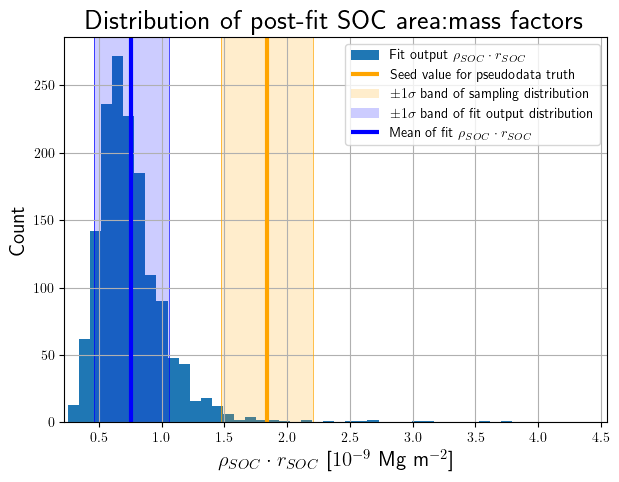

In [85]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

th = plt.hist(np.array(rrs),bins=40,zorder=0,label=r'Fit output $\rho_{SOC} \cdot r_{SOC}$')
#plt.vlines(rrs[0],ymin=0,ymax=30,color='orange')
plt.xlim([np.min(th[1])*0.9,np.max(th[1])*1.2])
plt.ylim([0,np.max(th[0])*1.05])
plt.grid()

plt.xlabel(r'$\rho_{SOC} \cdot r_{SOC}$ [$10^{-9}$ Mg m$^{-2}$]',fontsize=15)
plt.ylabel(r'Count',fontsize=15)
plt.title(r'Distribution of post-fit SOC area:mass factors',fontsize=20)

plt.vlines(trueSOCrr,ymin=0,ymax=np.max(th[0])*1.05,color='orange',label=r'Seed value for pseudodata truth',lw=3);
ax.add_patch(Rectangle((trueSOCrr*0.8,0),trueSOCrr*0.4,np.max(th[0])*1.05,facecolor="orange",alpha=0.2,label=r'$\pm1\sigma$ band of sampling distribution'));


# Empirical average and variance are computed
avg = np.mean(np.array(rrs))
sd = np.sqrt(np.var(np.array(rrs)))
ax.add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="blue",alpha=0.2,label=r'$\pm1\sigma$ band of fit output distribution'));
plt.vlines(avg,ymin=0,ymax=np.max(th[0])*1.05,color='blue',label=r'Mean of fit $\rho_{SOC}\cdot r_{SOC}$',lw=3);
ax.vlines(trueSOCrr*0.8,ymin=0,ymax=np.max(th[0])*1.05,color='orange',lw=0.5);
ax.vlines(trueSOCrr*1.2,ymin=0,ymax=np.max(th[0])*1.05,color='orange',lw=0.5);
ax.vlines(avg-sd,ymin=0,ymax=np.max(th[0])*1.05,color='blue',lw=0.5,zorder=1);
ax.vlines(avg+sd,ymin=0,ymax=np.max(th[0])*1.05,color='blue',lw=0.5,zorder=1);

plt.legend(loc='best')
print(avg,sd)

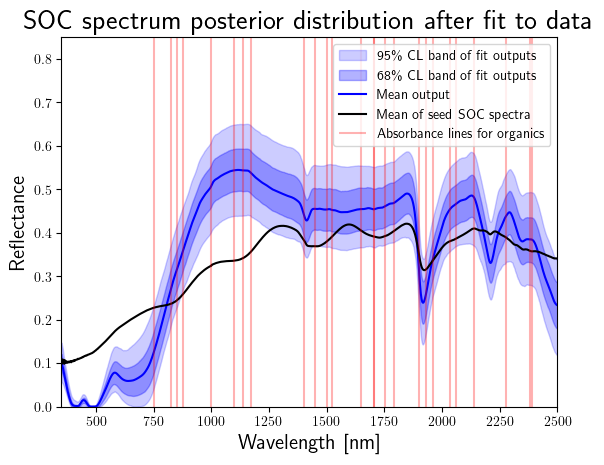

In [95]:
#plt.fill_between(XF,np.quantile(socspecs,0.995,axis=1),np.quantile(socspecs,0.005,axis=1),color='blue',alpha=0.1,label=r'99\% CL band')
plt.fill_between(XF,np.quantile(socspecs,0.975,axis=1),np.quantile(socspecs,0.025,axis=1),color='blue',alpha=0.2,label=r'95\% CL band of fit outputs')
plt.fill_between(XF,np.quantile(socspecs,0.84,axis=1),np.quantile(socspecs,0.16,axis=1),color='blue',alpha=0.3,label=r'68\% CL band of fit outputs')

#plt.plot(XF,np.mean(socspecs,axis=1), color='orange',lw=0.5, label=r'Mean of fit outputs');

plt.plot(XF,np.mean(socspecs,axis=1), color='blue', label=r'Mean output');
plt.plot(XF,seedFsoc, color='black', label=r'Mean of seed SOC spectra');

plt.xlim([350.0,2500.0])
plt.ylim([0.0,0.85])
plt.xlabel(r'Wavelength [nm]',fontsize=15)
plt.ylabel(r'Reflectance',fontsize=15)
plt.title(r'SOC spectrum posterior distribution after fit to data',fontsize=20)
plt.vlines(organicTroughs,ymin=0.0,ymax=0.85, color='red', alpha=0.3, label="Absorbance lines for organics")

plt.legend(loc='best');

In [81]:
socspecs[:,861] = socspecs[:,862]
socspecs[:,1046] = socspecs[:,1047]
rrs[861] = rrs[862]
rrs[1046] = rrs[1047]

In [82]:
np.min(np.array(rrs))

0.25077817865015944

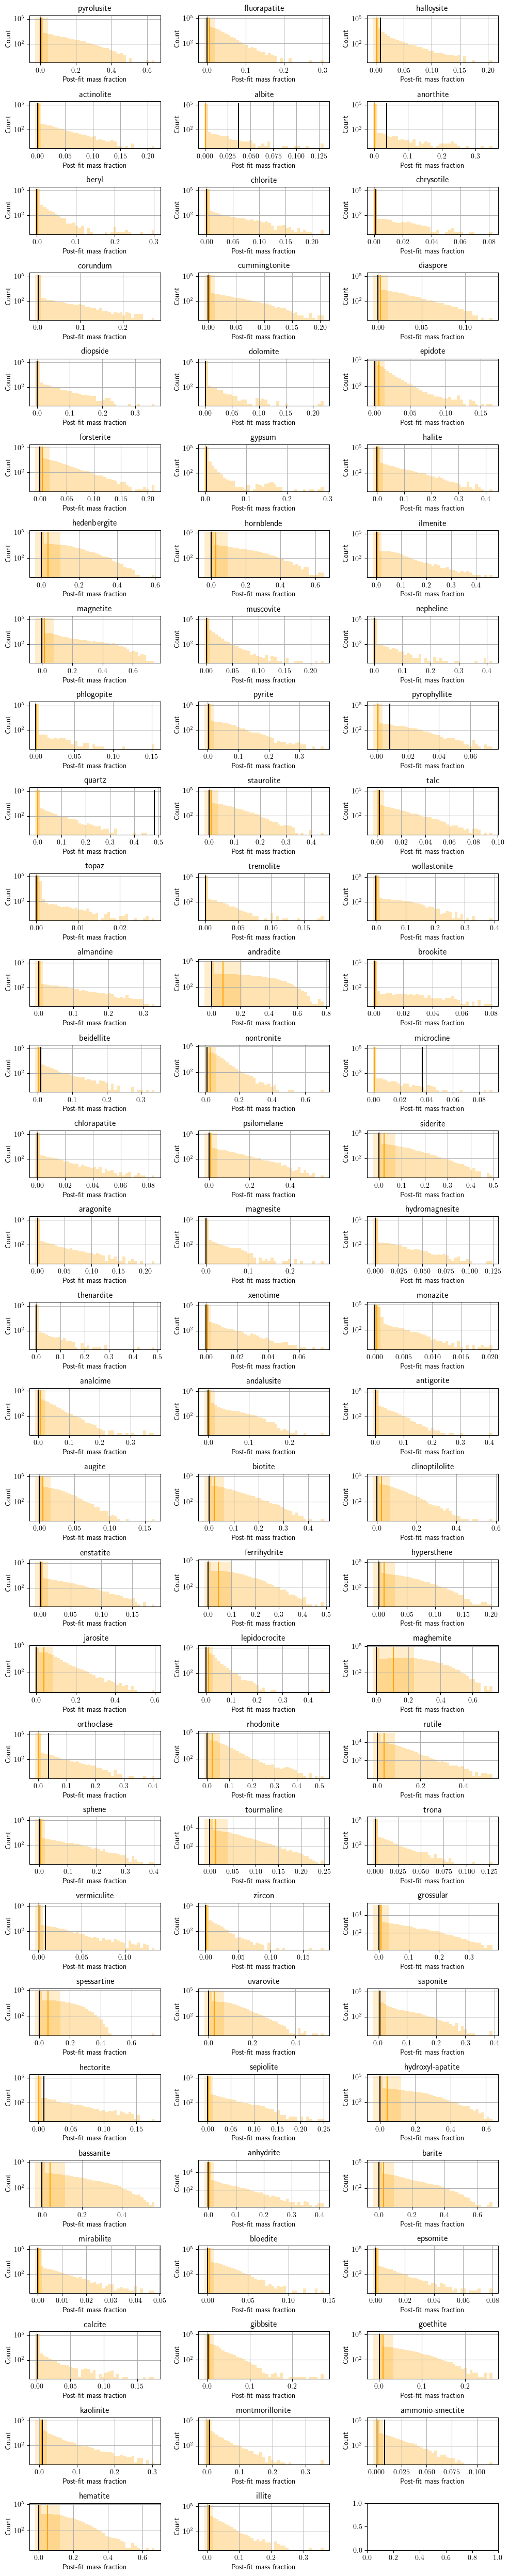

In [23]:
f, axarr = plt.subplots(int(np.ceil(KEndmembers/3.)),3,figsize=(10,50))

curr_row = 0
index = 0

for iEndmember in range(ms.shape[1]):

    col = index % 3
    # plot endmember distribution histogram
    th = axarr[curr_row,col].hist(ms[:,iEndmember,:].flatten(),bins=40,color='orange',alpha=0.3)
    
    # add mean and standard deviation bar overlay
    avg = np.mean(ms[:,iEndmember,:].flatten())
    sd = np.sqrt(np.var(ms[:,iEndmember,:].flatten()))
    axarr[curr_row,col].add_patch(Rectangle((avg-sd,0),sd*2,np.max(th[0])*1.05,facecolor="orange",alpha=0.2));
    axarr[curr_row,col].vlines(avg, ymin=0,ymax=np.max(th[0])*1.05,color='orange')
    
    # style
    axarr[curr_row,col].set_title(endMemList[iEndmember])
    axarr[curr_row,col].set_xlabel("Post-fit mass fraction")
    axarr[curr_row,col].set_ylabel("Count")
    axarr[curr_row,col].grid()
    axarr[curr_row,col].set_yscale('log')
    
    if endMemList[iEndmember] in seedMsDict :
        axarr[curr_row,col].vlines(seedMsDict[endMemList[iEndmember]],ymin=0,ymax=np.max(th[0]*1.05),color="black")

    # we have finished the current row, so increment row counter
    if col == 2 :
        curr_row += 1
    index +=1
    
    
f.tight_layout()
plt.show()